Jade Hochschule - Standort Oldenburg<br>
Fachbereich: Bauwesen Geoinformation Gesundheitstechnologie<br>
Studiengang: Geoinformationswissenschaften (M.Sc.)

<center><img src="https://www.jade-hs.de/fileadmin/_migrated/pics/Logo_JadeHochschule_7.jpg" width="400" /></center>

# <center>Raumzeitliche Analyse der Ausbreitung von COVID-19 in Deutschland</center>

**<center>Masterprojekt<br>
Wintersemester 2021/22</center>**

Erarbeitet von: &hairsp; Ricarda Sodermanns (6020924), ricarda.sodermanns@student.jade-hs.de<br>
&emsp; &emsp; &emsp; &emsp; &emsp; &ensp; Nicklas Meyer (6020989), nicklas.meyer@student.jade-hs.de

&emsp; &emsp; &emsp; &emsp; &emsp; &ensp; Oldenburg, 24. Januar 2022

Prüfer: &emsp; &emsp; &emsp; Prof. Dr. rer. nat. habil. Roland Pesch

## Gliederung

* [Datenimport](#datenimport)
* [Datensichtung](#datensichtung)
* [Datenvorbereitung](#datenvorbereitung)
* [Analyse](#analyse)
    * [Verlauf](#analyse-verlauf)
    * [Kartendarstellung der 7-Tage-Inzidenz](#analyse-map)
    * [HotSpot-Analyse](#analyse-hsa)
    * [Ausreißer-Analyse](#analyse-outlier)
    * [Space Time Cubes](#analyse-stc)
        * [Space Time Cubes berechnen](#analyse-stc-create)
        * [Emerging Hot Spot Analyse](#analyse-stc-emerg)
        * [Visualisierung in 3D](#analyse-stc-vis3D)
        * [Time Series Clustering](#analyse-stc-clust)
* [Datenexport](#export)

Zur Durchführung des Skripts sollte in der ArcGIS-Enterprise Umgebung ein Ordner mit dem Namen 'Masterprojekt' erstellt werden, da dort zum Teil Ergebnisse abgespeichert werden.

### Imports

Import der benötigten Pakete

In [116]:
# Standard
import os
import pandas as pd
import numpy

# ArcGIS (Geofunktonalitäten)
import arcgis
from arcgis.gis import GIS
from arcgis import geoanalytics
from arcgis.features import SpatialDataFrame
from arcgis import features
import arcpy

# Matplotlib (Diagramme)
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib

# Diverses
import zipfile
from copy import deepcopy
from datetime import datetime

#### arcpy-Workspace

Für die arcpy-Funktionen wird ein Workspace benötigt. Dieser wird im Home-Verzeichnis auf dem ArcGIS-Enterprise angelegt und dort eine Geodatabase zum Speichern der Ergebnisse erzeugt.

In [117]:
home_dir = os.path.join(os.getcwd(), 'home')
if not arcpy.Exists(os.path.join(home_dir, 'Results.gdb')):
    arcpy.CreateFileGDB_management(home_dir, 'Results.gdb')

In [118]:
arcpy.env.workspace = os.path.join(home_dir,'Results.gdb')
results_dir = os.path.join(home_dir,'Results.gdb')

## Datenimport <a class="anchor" id="datenimport"></a>

### Karte erstellen

Erzeugen einer Karte zur Darstellung der Layerdaten.

In [119]:
gis = GIS(url="https://arcgis.services.fbbgg.hs-woe.de/arcgis")
map = gis.map("Germany")
map

MapView(layout=Layout(height='400px', width='100%'))

### Layer: Kreisgrenzen

Einladen der Kreisgrenzen als Polygondaten. Die Daten können direkt aus dem ArcGIS-Hub als Layer-Datei verwendet werden.
Verwendet werden die Landkreisdaten des RKI mit Coronadaten, um die zu den Daten passenden Geometrien (Berlin in Stadteile aufgeteilt) sowie Einwohnerzahlen pro Landkreis zu erhalten.

Quelle: Robert Koch-Institut (RKI), dl-de/by-2-0

In [5]:
# Item Added From Toolbar
# Title: RKI Corona Landkreise | Type: Feature Service | Owner: help1@esri
agol_gis = GIS(set_active=False)
kreise = agol_gis.content.get("917fc37a709542548cc3be077a786c17")
kreise

<Item title:"RKI Corona Landkreise" type:Feature Layer Collection owner:help1@esri>

Diese Daten werden in der zuvor erzeugten Karte dargestellt.

In [6]:
map.add_layer(kreise)

Umwandeln der Layerdaten in ein "spatially-enabled" Dataframe um mit den Daten im Notebook arbeiten zu können und aber die geografischen Informationen beizubehalten.

In [7]:
kreise_df = pd.DataFrame.spatial.from_layer(kreise.layers[0])

### Corona-Daten

Einladen der tagesaktuellen Coronadaten für den gesamten Zeitraum. Die Daten können direkt aus dem ArcGIS-Hub als CSV-Datei verwendet werden.

Quelle: Robert Koch-Institut (RKI), dl-de/by-2-0

In [10]:
# Item Added From Toolbar
# Title: RKI_COVID19 | Type: CSV | Owner: help6@esri
agol_gis = GIS(set_active=False)
data = agol_gis.content.get("f10774f1c63e40168479a1feb6c7ca74")
data

<Item title:"RKI_COVID19" type:CSV owner:help6@esri>

Umwandeln der CSV-Daten in ein Pandas-Dataframe. Dabei werden die Spalten 'Meldedatum', 'Datenstand' und 'Refdatum' als Datum abgespeichert.

In [11]:
data_csv = data.get_data()
data_df = pd.read_csv(data_csv, parse_dates=['Meldedatum', 'Datenstand', 'Refdatum'])

## Datensichtung <a class="anchor" id="datensichtung"></a>

### Attributtabelle

Sichten des Aufbaus der Corona-Daten durch Ausgabe der Größe, Spalten und Spaltentypen der Daten.

In [12]:
data_df.shape

(3627499, 18)

In [13]:
data_df.columns

Index(['FID', 'IdBundesland', 'Bundesland', 'Landkreis', 'Altersgruppe',
       'Geschlecht', 'AnzahlFall', 'AnzahlTodesfall', 'Meldedatum',
       'IdLandkreis', 'Datenstand', 'NeuerFall', 'NeuerTodesfall', 'Refdatum',
       'NeuGenesen', 'AnzahlGenesen', 'IstErkrankungsbeginn', 'Altersgruppe2'],
      dtype='object')

In [14]:
print(data_df.dtypes)

FID                              int64
IdBundesland                     int64
Bundesland                      object
Landkreis                       object
Altersgruppe                    object
Geschlecht                      object
AnzahlFall                       int64
AnzahlTodesfall                  int64
Meldedatum              datetime64[ns]
IdLandkreis                      int64
Datenstand                      object
NeuerFall                        int64
NeuerTodesfall                   int64
Refdatum                datetime64[ns]
NeuGenesen                       int64
AnzahlGenesen                    int64
IstErkrankungsbeginn             int64
Altersgruppe2                   object
dtype: object


Sichten von Anfang und Ende des Dataframes, um Aufbau der Daten zu überprüfen.

In [15]:
data_df.head()

,FID,IdBundesland,Bundesland,Landkreis,Altersgruppe,Geschlecht,AnzahlFall,AnzahlTodesfall,Meldedatum,IdLandkreis,Datenstand,NeuerFall,NeuerTodesfall,Refdatum,NeuGenesen,AnzahlGenesen,IstErkrankungsbeginn,Altersgruppe2
0,1,1,Schleswig-Holstein,SK Flensburg,A00-A04,M,1,0,2020-09-30,1001,"20.01.2022, 00:00 Uhr",0,-9,2020-09-30,0,1,0,Nicht übermittelt
1,2,1,Schleswig-Holstein,SK Flensburg,A00-A04,M,1,0,2020-10-29,1001,"20.01.2022, 00:00 Uhr",0,-9,2020-10-29,0,1,0,Nicht übermittelt
2,3,1,Schleswig-Holstein,SK Flensburg,A00-A04,M,1,0,2020-11-03,1001,"20.01.2022, 00:00 Uhr",0,-9,2020-11-03,0,1,0,Nicht übermittelt
3,4,1,Schleswig-Holstein,SK Flensburg,A00-A04,M,1,0,2020-11-20,1001,"20.01.2022, 00:00 Uhr",0,-9,2020-11-19,0,1,1,Nicht übermittelt
4,5,1,Schleswig-Holstein,SK Flensburg,A00-A04,M,1,0,2020-11-23,1001,"20.01.2022, 00:00 Uhr",0,-9,2020-11-18,0,1,1,Nicht übermittelt


In [16]:
data_df.tail()

,FID,IdBundesland,Bundesland,Landkreis,Altersgruppe,Geschlecht,AnzahlFall,AnzahlTodesfall,Meldedatum,IdLandkreis,Datenstand,NeuerFall,NeuerTodesfall,Refdatum,NeuGenesen,AnzahlGenesen,IstErkrankungsbeginn,Altersgruppe2
3627494,3627495,16,Thüringen,LK Altenburger Land,A60-A79,W,1,0,2020-04-22,16077,"20.01.2022, 00:00 Uhr",0,-9,2020-04-17,0,1,1,Nicht übermittelt
3627495,3627496,16,Thüringen,LK Altenburger Land,A60-A79,W,1,0,2020-05-18,16077,"20.01.2022, 00:00 Uhr",0,-9,2020-05-14,0,1,1,Nicht übermittelt
3627496,3627497,16,Thüringen,LK Altenburger Land,A60-A79,W,1,0,2020-05-27,16077,"20.01.2022, 00:00 Uhr",0,-9,2020-05-27,0,1,0,Nicht übermittelt
3627497,3627498,16,Thüringen,LK Altenburger Land,A60-A79,W,1,0,2020-09-12,16077,"20.01.2022, 00:00 Uhr",0,-9,2020-09-08,0,1,1,Nicht übermittelt
3627498,3627499,16,Thüringen,LK Altenburger Land,A60-A79,W,1,0,2020-10-09,16077,"20.01.2022, 00:00 Uhr",0,-9,2020-10-09,0,1,0,Nicht übermittelt


## Datenvorbereitung <a class="anchor" id="datenvorbereitung"></a>

### Coronadaten

#### Aggregieren nach Tag und Landkreis

Da in der folgenden Analyse nicht auf Alter und Geschlecht der Personen eingegangen wird, wird durch eine Aggregation der Daten nur ein Eintrag pro Tag mit der Anzahl der Fälle, Todesfälle und Genesenen erzeugt. Im Zuge dessen werden nur die für die weitere Analyse wichtigen Spalten in das neue Dataframe überführt. Außerdem wird die Landkreis-ID auch als fünf-stelliger String abgelegt.

In [17]:
data_df_aggr = data_df[['IdBundesland','Bundesland','IdLandkreis','Landkreis','Meldedatum','AnzahlFall','AnzahlTodesfall','AnzahlGenesen']].groupby(['IdBundesland','Bundesland','IdLandkreis','Landkreis','Meldedatum']).sum()
data_df_aggr.reset_index(inplace = True, drop = False)
data_df_aggr['IdLandkreis_str'] = data_df_aggr['IdLandkreis'].astype(str).str.zfill(5)
data_df_aggr.head()

,IdBundesland,Bundesland,IdLandkreis,Landkreis,Meldedatum,AnzahlFall,AnzahlTodesfall,AnzahlGenesen,IdLandkreis_str
0,1,Schleswig-Holstein,1001,SK Flensburg,2020-03-14,4,0,4,01001
1,1,Schleswig-Holstein,1001,SK Flensburg,2020-03-18,2,0,2,01001
2,1,Schleswig-Holstein,1001,SK Flensburg,2020-03-19,4,0,4,01001
3,1,Schleswig-Holstein,1001,SK Flensburg,2020-03-20,2,0,2,01001
4,1,Schleswig-Holstein,1001,SK Flensburg,2020-03-21,1,0,1,01001


### Kreise

#### AGS in Berliner Bezirke

Berlin ist in den Coronadaten in zwölf Bezirke aufgeteilt. Die Polygondaten dazu liegen vor, allerdings ist dort der allgemeine Gemeindeschlüssel (AGS), der später zur Verbindung der Daten als Landkreis-ID dient, nicht vorhanden. Der dafür benötigte Schlüssel liegt in den Daten aber als Regionalschlüssel (RS) vor uns wird in den betreffenden Bezirken nun in die Spalte 'AGS' übertragen.

In [18]:
for index, kreis in kreise_df.loc[kreise_df['AGS'].isnull()].iterrows():
    kreise_df.at[index, 'AGS'] = kreise_df.at[index, 'RS']
kreise_df.loc[kreise_df['BL_ID'] == '11']

,OBJECTID,ADE,GF,BSG,RS,AGS,SDV_RS,GEN,BEZ,IBZ,...,recovered,EWZ_BL,cases7_bl_per_100k,cases7_bl,death7_bl,cases7_lk,death7_lk,cases7_per_100k_txt,AdmUnitId,SHAPE
399,404,NaN,NaN,NaN,11012,11012,None,Berlin Reinickendorf,Bezirk,NaN,...,None,3664088,1154.202628,42291,2,2477,1,"953,7",11012,"{""rings"": [[[792389.254807112, 5839502.6115011..."
400,405,NaN,NaN,NaN,11004,11004,None,Berlin Charlottenburg-Wilmersdorf,Bezirk,NaN,...,None,3664088,1154.202628,42291,2,3426,0,"1083,4",11004,"{""rings"": [[[793095.198362989, 5828151.5797928..."
401,406,NaN,NaN,NaN,11009,11009,None,Berlin Treptow-Köpenick,Bezirk,NaN,...,None,3664088,1154.202628,42291,2,2697,0,"987,9",11009,"{""rings"": [[[811538.542027648, 5814380.5558578..."
402,407,NaN,NaN,NaN,11003,11003,None,Berlin Pankow,Bezirk,NaN,...,None,3664088,1154.202628,42291,2,4399,0,"1088,4",11003,"{""rings"": [[[804887.108273519, 5839487.9793484..."
403,408,NaN,NaN,NaN,11008,11008,None,Berlin Neukölln,Bezirk,NaN,...,None,3664088,1154.202628,42291,2,5166,0,"1621,9",11008,"{""rings"": [[[802663.802804605, 5824408.6609931..."
404,409,NaN,NaN,NaN,11011,11011,None,Berlin Lichtenberg,Bezirk,NaN,...,None,3664088,1154.202628,42291,2,3119,1,"1068,1",11011,"{""rings"": [[[807143.217535185, 5823410.5725075..."
405,410,NaN,NaN,NaN,11010,11010,None,Berlin Marzahn-Hellersdorf,Bezirk,NaN,...,None,3664088,1154.202628,42291,2,564,0,"205,8",11010,"{""rings"": [[[813266.912876663, 5823563.2786502..."
406,411,NaN,NaN,NaN,11005,11005,None,Berlin Spandau,Bezirk,NaN,...,None,3664088,1154.202628,42291,2,3368,0,"1407,0",11005,"{""rings"": [[[786759.034879274, 5831877.2038761..."
407,412,NaN,NaN,NaN,11006,11006,None,Berlin Steglitz-Zehlendorf,Bezirk,NaN,...,None,3664088,1154.202628,42291,2,2040,0,"698,8",11006,"{""rings"": [[[793370.529199325, 5821756.8627222..."
408,413,NaN,NaN,NaN,11001,11001,None,Berlin Mitte,Bezirk,NaN,...,None,3664088,1154.202628,42291,2,8563,0,"2286,0",11001,"{""rings"": [[[796652.481997282, 5832431.7310471..."


#### Geometrie und Daten trennen

Für eine performantere Analyse werden die Geometrie und die restlichen Daten voneinander getrennt.

Endprodukte sind die Kreisgeometrien (*kreise_geom*) und die Kreisdaten mit den Einwohnerzahlen für den Landkreis (*kreise_ewz*).

In [19]:
kreise_geom = kreise_df[['AGS', 'SHAPE', 'Shape__Area', 'Shape__Length']]
kreise_geom['AGS_int'] = kreise_geom['AGS'].astype(int)
kreise_ewz = kreise_df[['AGS', 'EWZ', 'EWZ_BL']]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Außerdem werden die Einwohnerzahlen für die einzelnen Bundesländer in einem weiteren Dataframe (*bl_ewz*) gespeichert.

Dieses Dataframe hat pro Landkreis einen Eintrag. Damit nur noch ein Eintrag pro Bundesland bestehen bleibt, werden die Daten aggregiert (*bl_id*).

In [20]:
bl_ewz = kreise_df[['BL_ID', 'BL', 'EWZ_BL']]
bl_ewz['BL_ID_str'] = bl_ewz['BL_ID'].astype(str).str.zfill(2)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [21]:
bl_id = bl_ewz[['BL_ID','BL_ID_str','BL','EWZ_BL']].groupby(['BL_ID','BL_ID_str','BL','EWZ_BL']).sum()
bl_id.reset_index(inplace = True, drop = False)
bl_id.head()

,BL_ID,BL_ID_str,BL,EWZ_BL
0,1,01,Schleswig-Holstein,2910875
1,10,10,Saarland,983991
2,11,11,Berlin,3664088
3,12,12,Brandenburg,2531071
4,13,13,Mecklenburg-Vorpommern,1610774


### Join

Die nicht-geometrischen Kreisdaten werden mit den Coronadaten über AGS und die Landkreis-ID verbunden (*data_ewz*).

In [22]:
data_ewz = pd.merge(kreise_ewz, data_df_aggr, left_on='AGS', right_on="IdLandkreis_str", how='right')
data_ewz.head()

,AGS,EWZ,EWZ_BL,IdBundesland,Bundesland,IdLandkreis,Landkreis,Meldedatum,AnzahlFall,AnzahlTodesfall,AnzahlGenesen,IdLandkreis_str
0,01001,89934,2910875,1,Schleswig-Holstein,1001,SK Flensburg,2020-03-14,4,0,4,01001
1,01001,89934,2910875,1,Schleswig-Holstein,1001,SK Flensburg,2020-03-18,2,0,2,01001
2,01001,89934,2910875,1,Schleswig-Holstein,1001,SK Flensburg,2020-03-19,4,0,4,01001
3,01001,89934,2910875,1,Schleswig-Holstein,1001,SK Flensburg,2020-03-20,2,0,2,01001
4,01001,89934,2910875,1,Schleswig-Holstein,1001,SK Flensburg,2020-03-21,1,0,1,01001


In [23]:
kreise_id = data_ewz[['IdLandkreis','IdLandkreis_str','Landkreis','EWZ','IdBundesland','Bundesland','EWZ_BL']].groupby(['IdLandkreis','IdLandkreis_str','Landkreis','EWZ','IdBundesland','Bundesland','EWZ_BL']).sum()
kreise_id.reset_index(inplace = True, drop = False)
kreise_id.head()

,IdLandkreis,IdLandkreis_str,Landkreis,EWZ,IdBundesland,Bundesland,EWZ_BL
0,1001,01001,SK Flensburg,89934,1,Schleswig-Holstein,2910875
1,1002,01002,SK Kiel,246601,1,Schleswig-Holstein,2910875
2,1003,01003,SK Lübeck,215846,1,Schleswig-Holstein,2910875
3,1004,01004,SK Neumünster,79905,1,Schleswig-Holstein,2910875
4,1051,01051,LK Dithmarschen,133251,1,Schleswig-Holstein,2910875


#### Auf Bundesländer aggregieren

Für eine Auswertung pro Bundesland werden die Daten auf Bundeslandebene aggregiert. Dabei werden alle Landkreisfälle pro Tag aufsummiert.

In [24]:
data_bl = data_ewz[['IdBundesland','Bundesland','Meldedatum','AnzahlFall','AnzahlTodesfall','AnzahlGenesen', 'EWZ_BL']].groupby(['IdBundesland','Bundesland','Meldedatum', 'EWZ_BL']).sum()
data_bl.reset_index(inplace = True, drop = False)
data_bl['IdBundesland_str'] = data_bl['IdBundesland'].astype(str).str.zfill(2)
data_bl.head()

,IdBundesland,Bundesland,Meldedatum,EWZ_BL,AnzahlFall,AnzahlTodesfall,AnzahlGenesen,IdBundesland_str
0,1,Schleswig-Holstein,2020-02-28,2910875,1,0,1,01
1,1,Schleswig-Holstein,2020-02-29,2910875,1,0,1,01
2,1,Schleswig-Holstein,2020-03-02,2910875,2,0,2,01
3,1,Schleswig-Holstein,2020-03-03,2910875,1,0,1,01
4,1,Schleswig-Holstein,2020-03-05,2910875,1,0,1,01


### Inzidenzberechnung

Für die korrekte Berechnung der 7-Tage Inzidenz wird eine Liste aller Tage als Datum in dem zu betrachtenden Bereich erstellt. Dieser beginnt mit dem frühsten in den Daten auftrenden Fall und endet mit dem Datum des neusten Eintrag.

In [25]:
date_list = pd.date_range(start=min(data_bl['Meldedatum']), end=max(data_bl['Meldedatum']), freq='D')
date_list

DatetimeIndex(['2020-01-02', '2020-01-03', '2020-01-04', '2020-01-05',
               '2020-01-06', '2020-01-07', '2020-01-08', '2020-01-09',
               '2020-01-10', '2020-01-11',
               ...
               '2022-01-10', '2022-01-11', '2022-01-12', '2022-01-13',
               '2022-01-14', '2022-01-15', '2022-01-16', '2022-01-17',
               '2022-01-18', '2022-01-19'],
              dtype='datetime64[ns]', length=749, freq='D')

Außerdem wird ein Dictionary mit 7 Einträgen mit 0.0 benötigt.

In [26]:
values = [0.0,0.0,0.0,0.0,0.0,0.0,0.0] 
dict_clear = dict(zip(range(7), values))
dict_clear

{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0}

#### Bundesländer

##### Bundesländer: Tagesinzidenz berechnen

Für die Inzidenzberechnung wird zunächst die Tagesinzidenz, also Fälle/Todesfälle/Genesenen pro 100.000 Einwohner berechnet. Diese Werte werden als neue Spalte dem Dataframe hinzugefügt.

In [27]:
data_bl['FaelleEWZ'] = (data_bl['AnzahlFall'] / data_bl['EWZ_BL']) * 100000
data_bl['TodesfaelleEWZ'] = (data_bl['AnzahlTodesfall'] / data_bl['EWZ_BL']) * 100000
data_bl['GeneseneEWZ'] = (data_bl['AnzahlGenesen'] / data_bl['EWZ_BL']) * 100000
data_bl.tail()

,IdBundesland,Bundesland,Meldedatum,EWZ_BL,AnzahlFall,AnzahlTodesfall,AnzahlGenesen,IdBundesland_str,FaelleEWZ,TodesfaelleEWZ,GeneseneEWZ
10902,16,Thüringen,2022-01-15,2120237,388,0,3,16,18.299841,0.000000,0.141494
10903,16,Thüringen,2022-01-16,2120237,192,0,0,16,9.055591,0.000000,0.000000
10904,16,Thüringen,2022-01-17,2120237,634,1,6,16,29.902318,0.047165,0.282987
10905,16,Thüringen,2022-01-18,2120237,1308,0,10,16,61.691217,0.000000,0.471645
10906,16,Thüringen,2022-01-19,2120237,1198,0,1,16,56.503117,0.000000,0.047165


##### Bundesländer: 7-Tageinzidenz berechnen

Bei der Berechnung der 7-Tagesinzidenz muss beachtet werden, dass einige Meldedaten (besonders zu Beginn der Pandemie) nicht für alle Bundesländer vorhanden sind, weil dort keine Fälle auftraten oder es Probleme bei der Meldung der Fälle gab.
Zunächst werden die drei dafür benötigten Spalten 'FaelleEWZ_7', 'TodesfaelleEWZ_7' und 'GeneseneEWZ_7' angelegt.

Die eigentliche Berechnung erfolgt über geschachtelte Schleifen.
Pro Bundesland wird eine Vorlage für einen neuen Listeneintrag angelegt, falls ein neuer Eintrag durch ein fehlendes Meldedatum erstellt werden muss. Außerdem wird für die Fälle, Todesfälle und Genesene je ein Dictionary aus der zuvor angelegten Vorlage erstellt und ein Index angelegt.

Anschließend werden alle Meldedaten aus der zuvor erstellten Liste durchlaufen.

Ist ein Eintrag für den betrachteten Tag vorhanden, dann wird die aktuelle Tagesinzidenz der Fälle/Todesfälle/Genesenen in das jeweilige Dictionary an der Stelle des Tagesindex eingefügt. Außerdem werden die Spalten der 7-Tagesinzidenzen durch die Summe der im Dictionary enthaltenen Werte gefüllt.

Ist für das betrachtete Datum kein Eintrag vorhanden wird 0 in das jeweilige Dictionary an der Stelle des Tagesindex eingefügt. Außerdem wird die erstellte Vorlage mit dem  Datum und den 7-Tagesinzidenzen als Summe der im Dictionary enthaltenen Werte gefüllt. Diese Liste wird an eine Liste aller hinzuzufügenden Daten angehängt.

Sind alle Bundesländer und Tage durchlaufen wird die Liste mit den hinzuzufügenden Daten in ein Dataframe umgewandelt und an die Ursprungsdaten angehängt.

In [28]:
data_bl['FaelleEWZ_7'] = 0.0
data_bl['TodesfaelleEWZ_7'] = 0.0
data_bl['GeneseneEWZ_7'] = 0.0

temp_data = []

for index, bl in bl_id.iterrows():

    temp_list = [bl['BL_ID'], bl['BL'],0,bl['EWZ_BL'],0,0,0,bl['BL_ID_str'],0,0,0,0,0,0]

    dict_faelle = deepcopy(dict_clear)
    dict_todesfaelle = deepcopy(dict_clear)
    dict_genesene = deepcopy(dict_clear)
    index_dict = 0

    temp_bl = data_bl.loc[data_bl['IdBundesland_str'] == bl['BL_ID_str']]

    for day in date_list:
        index_day = index_dict%7

        temp = temp_bl.loc[data_bl['Meldedatum'] == day]
        if not temp.empty:
            i = temp.index[0]
            d = data_bl.iloc[i]
            dict_faelle[index_day] = d['FaelleEWZ']
            dict_todesfaelle[index_day] = d['TodesfaelleEWZ']
            dict_genesene[index_day] = d['GeneseneEWZ']

            data_bl.at[i, 'FaelleEWZ_7'] = sum(dict_faelle.values())
            data_bl.at[i, 'TodesfaelleEWZ_7'] = sum(dict_todesfaelle.values())
            data_bl.at[i, 'GeneseneEWZ_7'] = sum(dict_genesene.values())
        else:
            dict_faelle[index_day] = 0
            dict_todesfaelle[index_day] = 0
            dict_genesene[index_day] = 0
            temp_list[2] = day
            temp_list[-3] = sum(dict_faelle.values())
            temp_list[-2] = sum(dict_todesfaelle.values())
            temp_list[-1] = sum(dict_genesene.values())
            temp_data.append(temp_list.copy())

        index_dict += 1

temp_df = pd.DataFrame(temp_data, columns=data_bl.columns)
data_bl = data_bl.append(temp_df, ignore_index=True)

Die ergänzten Daten mit den 7-Tagesinzidenzen werden nun nach Bundesland und Meldedatum sortiert.

In [29]:
data_bl.sort_values(['IdBundesland_str', 'Meldedatum'], inplace = True)
data_bl.reset_index(inplace = True, drop = True)

In [30]:
data_bl.head()

,IdBundesland,Bundesland,Meldedatum,EWZ_BL,AnzahlFall,AnzahlTodesfall,AnzahlGenesen,IdBundesland_str,FaelleEWZ,TodesfaelleEWZ,GeneseneEWZ,FaelleEWZ_7,TodesfaelleEWZ_7,GeneseneEWZ_7
0,1,Schleswig-Holstein,2020-01-02,2910875,0,0,0,01,0.0,0.0,0.0,0.0,0.0,0.0
1,1,Schleswig-Holstein,2020-01-03,2910875,0,0,0,01,0.0,0.0,0.0,0.0,0.0,0.0
2,1,Schleswig-Holstein,2020-01-04,2910875,0,0,0,01,0.0,0.0,0.0,0.0,0.0,0.0
3,1,Schleswig-Holstein,2020-01-05,2910875,0,0,0,01,0.0,0.0,0.0,0.0,0.0,0.0
4,1,Schleswig-Holstein,2020-01-06,2910875,0,0,0,01,0.0,0.0,0.0,0.0,0.0,0.0


#### Landkreise

Die Berechnung der 7-Tagesinzidenz für Landkreise funktioniert fast identisch zu der Berechnung der 7-Tagesinzidenz der Bundesländer

##### Landkreise: Tagesinzidenz berechnen

Für die Inzidenzberechnung wird zunächst die Tagesinzidenz, also Fälle/Todesfälle/Genesenen pro 100.000 Einwohner berechnet. Diese Werte werden als neue Spalte dem Dataframe hinzugefügt.

In [31]:
data_ewz['FaelleEWZ'] = (data_ewz['AnzahlFall'] / data_ewz['EWZ']) * 100000
data_ewz['TodesfaelleEWZ'] = (data_ewz['AnzahlTodesfall'] / data_ewz['EWZ']) * 100000
data_ewz['GeneseneEWZ'] = (data_ewz['AnzahlGenesen'] / data_ewz['EWZ']) * 100000
data_ewz.tail()

,AGS,EWZ,EWZ_BL,IdBundesland,Bundesland,IdLandkreis,Landkreis,Meldedatum,AnzahlFall,AnzahlTodesfall,AnzahlGenesen,IdLandkreis_str,FaelleEWZ,TodesfaelleEWZ,GeneseneEWZ
223182,16077,88356,2120237,16,Thüringen,16077,LK Altenburger Land,2022-01-14,17,0,0,16077,19.240346,0.0,0.0
223183,16077,88356,2120237,16,Thüringen,16077,LK Altenburger Land,2022-01-15,7,0,0,16077,7.922495,0.0,0.0
223184,16077,88356,2120237,16,Thüringen,16077,LK Altenburger Land,2022-01-17,23,0,0,16077,26.031056,0.0,0.0
223185,16077,88356,2120237,16,Thüringen,16077,LK Altenburger Land,2022-01-18,61,0,0,16077,69.038888,0.0,0.0
223186,16077,88356,2120237,16,Thüringen,16077,LK Altenburger Land,2022-01-19,17,0,0,16077,19.240346,0.0,0.0


#### Landkreise: 7-Tageinzidenz berechnen

Bei der Berechnung der 7-Tagesinzidenz muss beachtet werden, dass einige Meldedaten (besonders zu Beginn der Pandemie) nicht für alle Landkreise vorhanden sind, weil dort keine Fälle auftraten oder es Probleme bei der Meldung der Fälle gab.
Zunächst werden die drei dafür benötigten Spalten 'FaelleEWZ_7', 'TodesfaelleEWZ_7' und 'GeneseneEWZ_7' angelegt.

Die eigentliche Berechnung erfolgt über geschachtelte Schleifen.
Pro Landkreis wird eine Vorlage für einen neuen Listeneintrag angelegt, falls ein neuer Eintrag durch ein fehlendes Meldedatum erstellt werden muss. Außerdem wird für die Fälle, Todesfälle und Genesene je ein Dictionary aus der zuvor angelegten Vorlage erstellt und ein Index angelegt.

Anschließend werden alle Meldedaten aus der zuvor erstellten Liste durchlaufen.

Ist ein Eintrag für den betrachteten Tag vorhanden, dann wird die aktuelle Tagesinzidenz der Fälle/Todesfälle/Genesenen in das jeweilige Dictionary an der Stelle des Tagesindex eingefügt. Außerdem werden die Spalten der 7-Tagesinzidenzen durch die Summe der im Dictionary enthaltenen Werte gefüllt.

Ist für das betrachtete Datum kein Eintrag vorhanden wird 0 in das jeweilige Dictionary an der Stelle des Tagesindex eingefügt. Außerdem wird die erstellte Vorlage mit dem  Datum und den 7-Tagesinzidenzen als Summe der im Dictionary enthaltenen Werte gefüllt. Diese Liste wird an eine Liste aller hinzuzufügenden Daten angehängt.

Sind alle Landkreise und Tage durchlaufen wird die Liste mit den hinzuzufügenden Daten in ein Dataframe umgewandelt und an die Ursprungsdaten angehängt.

In [32]:
data_ewz['FaelleEWZ_7'] = 0.0
data_ewz['TodesfaelleEWZ_7'] = 0.0
data_ewz['GeneseneEWZ_7'] = 0.0

temp_data = []
bl = 0

for index, kreis in kreise_id.iterrows():

    temp_list = [kreis['IdLandkreis_str'],kreis['EWZ'],kreis['EWZ_BL'],kreis['IdBundesland'],kreis['Bundesland'],kreis['IdLandkreis'],kreis['Landkreis'],0,0,0,0,kreis['IdLandkreis_str'],0,0,0,0,0,0]

    dict_faelle = deepcopy(dict_clear)
    dict_todesfaelle = deepcopy(dict_clear)
    dict_genesene = deepcopy(dict_clear)
    index_dict = 0

    temp_kreis = data_ewz.loc[data_ewz['AGS'] == kreis['IdLandkreis_str']]

    for day in date_list:
        index_day = index_dict%7

        temp = temp_kreis.loc[data_ewz['Meldedatum'] == day]
        if not temp.empty:
            i = temp.index[0]
            d = data_ewz.iloc[i]
            dict_faelle[index_day] = d['FaelleEWZ']
            dict_todesfaelle[index_day] = d['TodesfaelleEWZ']
            dict_genesene[index_day] = d['GeneseneEWZ']

            data_ewz.at[i, 'FaelleEWZ_7'] = sum(dict_faelle.values())
            data_ewz.at[i, 'TodesfaelleEWZ_7'] = sum(dict_todesfaelle.values())
            data_ewz.at[i, 'GeneseneEWZ_7'] = sum(dict_genesene.values())
        else:
            dict_faelle[index_day] = 0
            dict_todesfaelle[index_day] = 0
            dict_genesene[index_day] = 0
            temp_list[7] = day
            temp_list[-3] = sum(dict_faelle.values())
            temp_list[-2] = sum(dict_todesfaelle.values())
            temp_list[-1] = sum(dict_genesene.values())
            temp_data.append(temp_list.copy())

        index_dict += 1
temp_df = pd.DataFrame(temp_data, columns=data_ewz.columns)
data_ewz = data_ewz.append(temp_df, ignore_index=True)

Die ergänzten Daten mit den 7-Tagesinzidenzen werden nun nach Landkreis und Meldedatum sortiert.

In [33]:
data_ewz.sort_values(['IdLandkreis_str', 'Meldedatum'], inplace = True)
data_ewz.reset_index(inplace = True, drop = True)

In [34]:
data_ewz.tail()

,AGS,EWZ,EWZ_BL,IdBundesland,Bundesland,IdLandkreis,Landkreis,Meldedatum,AnzahlFall,AnzahlTodesfall,AnzahlGenesen,IdLandkreis_str,FaelleEWZ,TodesfaelleEWZ,GeneseneEWZ,FaelleEWZ_7,TodesfaelleEWZ_7,GeneseneEWZ_7
307834,16077,88356,2120237,16,Thüringen,16077,LK Altenburger Land,2022-01-15,7,0,0,16077,7.922495,0.0,0.0,149.395627,1.131785,0.0
307835,16077,88356,2120237,16,Thüringen,16077,LK Altenburger Land,2022-01-16,0,0,0,16077,0.000000,0.0,0.0,146.000272,0.000000,0.0
307836,16077,88356,2120237,16,Thüringen,16077,LK Altenburger Land,2022-01-17,23,0,0,16077,26.031056,0.0,0.0,127.891711,0.000000,0.0
307837,16077,88356,2120237,16,Thüringen,16077,LK Altenburger Land,2022-01-18,61,0,0,16077,69.038888,0.0,0.0,164.108832,0.000000,0.0
307838,16077,88356,2120237,16,Thüringen,16077,LK Altenburger Land,2022-01-19,17,0,0,16077,19.240346,0.0,0.0,160.713477,0.000000,0.0


Zwischenspeichern der Landkreisdaten mit 7-Tages-Inzidenz, um eine Neuberechung umgehen zu können.

In [35]:
data_ewz.to_csv('home/data.csv', index=False)

In [36]:
data_ewz = pd.read_csv('home/data.csv', parse_dates=['Meldedatum'], dtype={'AGS': str, 'IdLandkreis_str': str})

In [37]:
data_ewz.tail()

,AGS,EWZ,EWZ_BL,IdBundesland,Bundesland,IdLandkreis,Landkreis,Meldedatum,AnzahlFall,AnzahlTodesfall,AnzahlGenesen,IdLandkreis_str,FaelleEWZ,TodesfaelleEWZ,GeneseneEWZ,FaelleEWZ_7,TodesfaelleEWZ_7,GeneseneEWZ_7
307834,16077,88356,2120237,16,Thüringen,16077,LK Altenburger Land,2022-01-15,7,0,0,16077,7.922495,0.0,0.0,149.395627,1.131785,0.0
307835,16077,88356,2120237,16,Thüringen,16077,LK Altenburger Land,2022-01-16,0,0,0,16077,0.000000,0.0,0.0,146.000272,0.000000,0.0
307836,16077,88356,2120237,16,Thüringen,16077,LK Altenburger Land,2022-01-17,23,0,0,16077,26.031056,0.0,0.0,127.891711,0.000000,0.0
307837,16077,88356,2120237,16,Thüringen,16077,LK Altenburger Land,2022-01-18,61,0,0,16077,69.038888,0.0,0.0,164.108832,0.000000,0.0
307838,16077,88356,2120237,16,Thüringen,16077,LK Altenburger Land,2022-01-19,17,0,0,16077,19.240346,0.0,0.0,160.713477,0.000000,0.0


## Analyse <a class="anchor" id="analyse"></a>

### Übersichtskarte

#### Daten auf Geometrie joinen

Joinen der Daten eines Tages mit den Geometrien, um eine Übersichtskarte erstellen zu können.

In [38]:
data_kreise_day = pd.merge(data_ewz.loc[data_ewz['Meldedatum']=='2021-12-28'], kreise_geom, left_on="IdLandkreis_str", right_on="AGS", how='right')
data_kreise_day.head()

,AGS_x,EWZ,EWZ_BL,IdBundesland,Bundesland,IdLandkreis,Landkreis,Meldedatum,AnzahlFall,AnzahlTodesfall,...,TodesfaelleEWZ,GeneseneEWZ,FaelleEWZ_7,TodesfaelleEWZ_7,GeneseneEWZ_7,AGS_y,SHAPE,Shape__Area,Shape__Length,AGS_int
0,01001,89934,2910875,1,Schleswig-Holstein,1001,SK Flensburg,2021-12-28,32,0,...,0.000000,34.469722,186.803656,0.000000,185.691729,01001,"{'rings': [[[526513.752884256, 6075133.4118775...",4.918293e+07,42752.592015,1001
1,01002,246601,2910875,1,Schleswig-Holstein,1002,SK Kiel,2021-12-28,123,0,...,0.000000,48.661603,165.854964,0.000000,164.232911,01002,"{'rings': [[[575841.569494392, 6032148.0317960...",1.122314e+08,104373.457289,1002
2,01003,215846,2910875,1,Schleswig-Holstein,1003,SK Lübeck,2021-12-28,101,0,...,0.000000,45.866034,102.387814,0.000000,101.461227,01003,"{'rings': [[[623056.150596513, 5983746.4452249...",2.116771e+08,146459.457897,1003
3,01004,79905,2910875,1,Schleswig-Holstein,1004,SK Neumünster,2021-12-28,26,0,...,0.000000,30.035667,163.944684,0.000000,161.441712,01004,"{'rings': [[[565015.651588687, 6000637.5134813...",7.140224e+07,54863.995416,1004
4,01051,133251,2910875,1,Schleswig-Holstein,1051,LK Dithmarschen,2021-12-28,91,1,...,0.750463,64.539853,255.157560,1.500927,243.150145,01051,"{'rings': [[[479877.791292057, 5990290.5867080...",1.425511e+09,250768.570200,1051


Erstellen eines anzeigbaren Layers für die Karte.

In [39]:
gis = GIS("home")
items = gis.content.search(query ='Corona-Übersicht')
for item in items:
    item.delete()
data_kreise_day_fl = data_kreise_day.spatial.to_featurelayer('Corona-Übersicht', tags=['Corona', 'COVID-19'], folder='Masterprojekt')

#### In Karte anzeigen

Anzeigen der Karte.

Dabei kann beim ersten Ausführen ein Fehler auftreten. Um diesen zu beheben muss die Zelle einmal mit gis=GIS("home") ausgeführt und die darauffolgende Zeile auskommentiert werden werden. Anschließend kann wieder die erste Zeile auskommentiert werden und die Zelle mit gis=GIS(url="https://arcgis.services.fbbgg.hs-woe.de/arcgis") ausgeführt werden.

In [41]:
#gis = GIS("home")
gis = GIS(url="https://arcgis.services.fbbgg.hs-woe.de/arcgis")
map = gis.map("Germany")
classed_color_renderer =  {"renderer":"ClassedColorRenderer", "field_name":"anzahl_fall" }
map.add_layer(data_kreise_day_fl, classed_color_renderer)
map

MapView(layout=Layout(height='400px', width='100%'))

### Verlauf <a class="anchor" id="analyse-verlauf"></a>

Um ein Verlaufdiagramm der Fälle/Todesfälle/Genesenen pro Bundesland zu erstellen muss zunächst eine Farbpalette erstellt werden und die Rahmenbedingungen gesetzt werden. Das Enddatum für das Diagramm wird auf den 02.01.2022 gesetzt. Anschließend werden alle Bundesländer nacheinander geplottet. Als letzter Schritt müssen alle Einstellungen des Diagramms gesetzt werden. Das Diagramm wird als PDF exportiert.

#### Diagramm Fälle

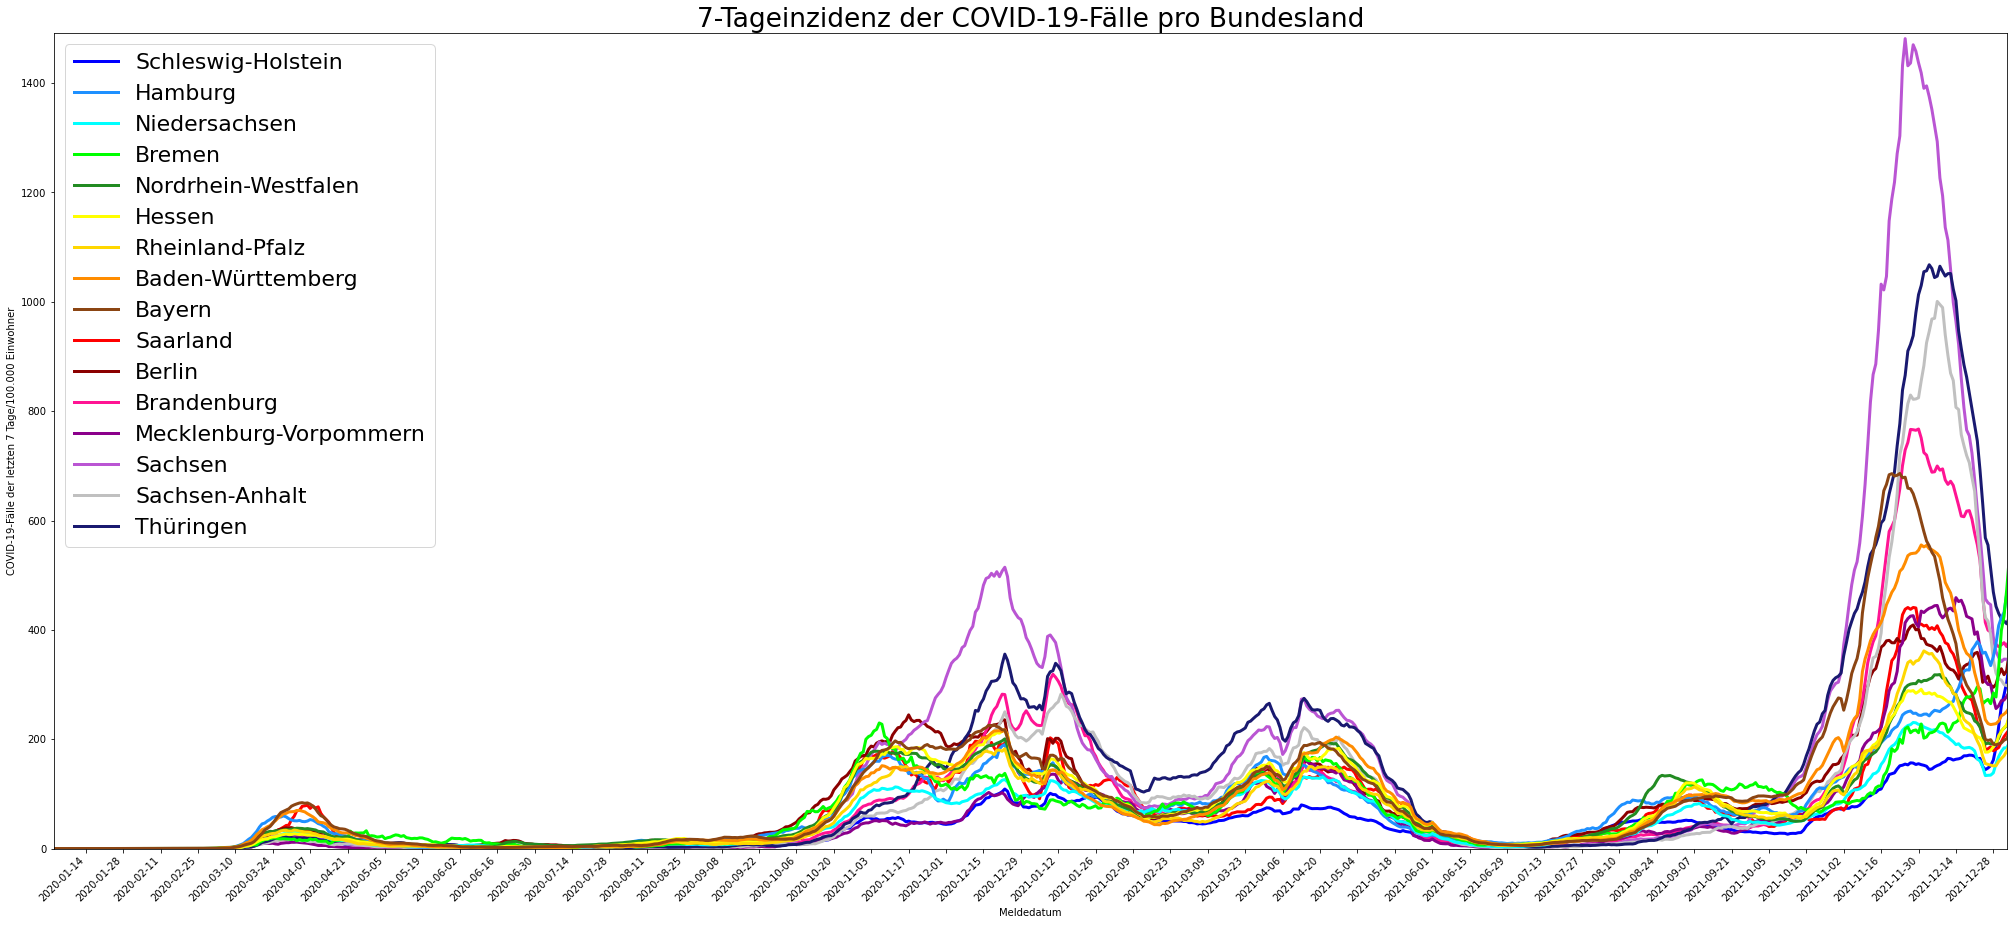

In [42]:
# Vorbereitung
col = {'01':'blue', '02':'dodgerblue', '03':'cyan', '04':'lime', '05':'forestgreen', '06':'yellow', '07':'gold', '08':'darkorange', '09':'saddlebrown', '10':'red', '11':'darkred', '12':'deeppink', '13':'darkmagenta', '14':'mediumorchid', '15':'silver', '16':'midnightblue'}
fig, ax = plt.subplots(figsize=(35,15))
y_max = max(data_bl['FaelleEWZ_7'])
x_min = min(data_bl['Meldedatum'])
x_max = datetime.strptime("02/01/22", '%d/%m/%y')

# Daten
for bl in bl_id['BL_ID_str']:
    plt.plot( data_bl.loc[data_bl['IdBundesland_str'] == bl]['Meldedatum'], data_bl.loc[data_bl['IdBundesland_str'] == bl]['FaelleEWZ_7'], color=col[bl], linewidth=3, label=bl_id.loc[bl_id['BL_ID_str'] == bl]['BL'].item())

# Einstellungen
plt.rc("font", size = 22)
plt.rc("axes", labelsize = 20)
plt.rc("legend", fontsize = 22)

plt.legend(loc='upper left')
plt.xlabel("Meldedatum")
plt.ylabel("COVID-19-Fälle der letzten 7 Tage/100.000 Einwohner")
plt.title("7-Tageinzidenz der COVID-19-Fälle pro Bundesland")
plt.xlim([x_min, x_max])
plt.ylim([0, y_max+10])
plt.xticks(rotation=45, ha='right')

ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))

handles, labels = plt.gca().get_legend_handles_labels()
order = [0,8,9,10,11,12,13,14,15,1,2,3,4,5,6,7]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

plt.savefig('VerlaufFaelle.pdf')  

#### Diagramm Todesfälle

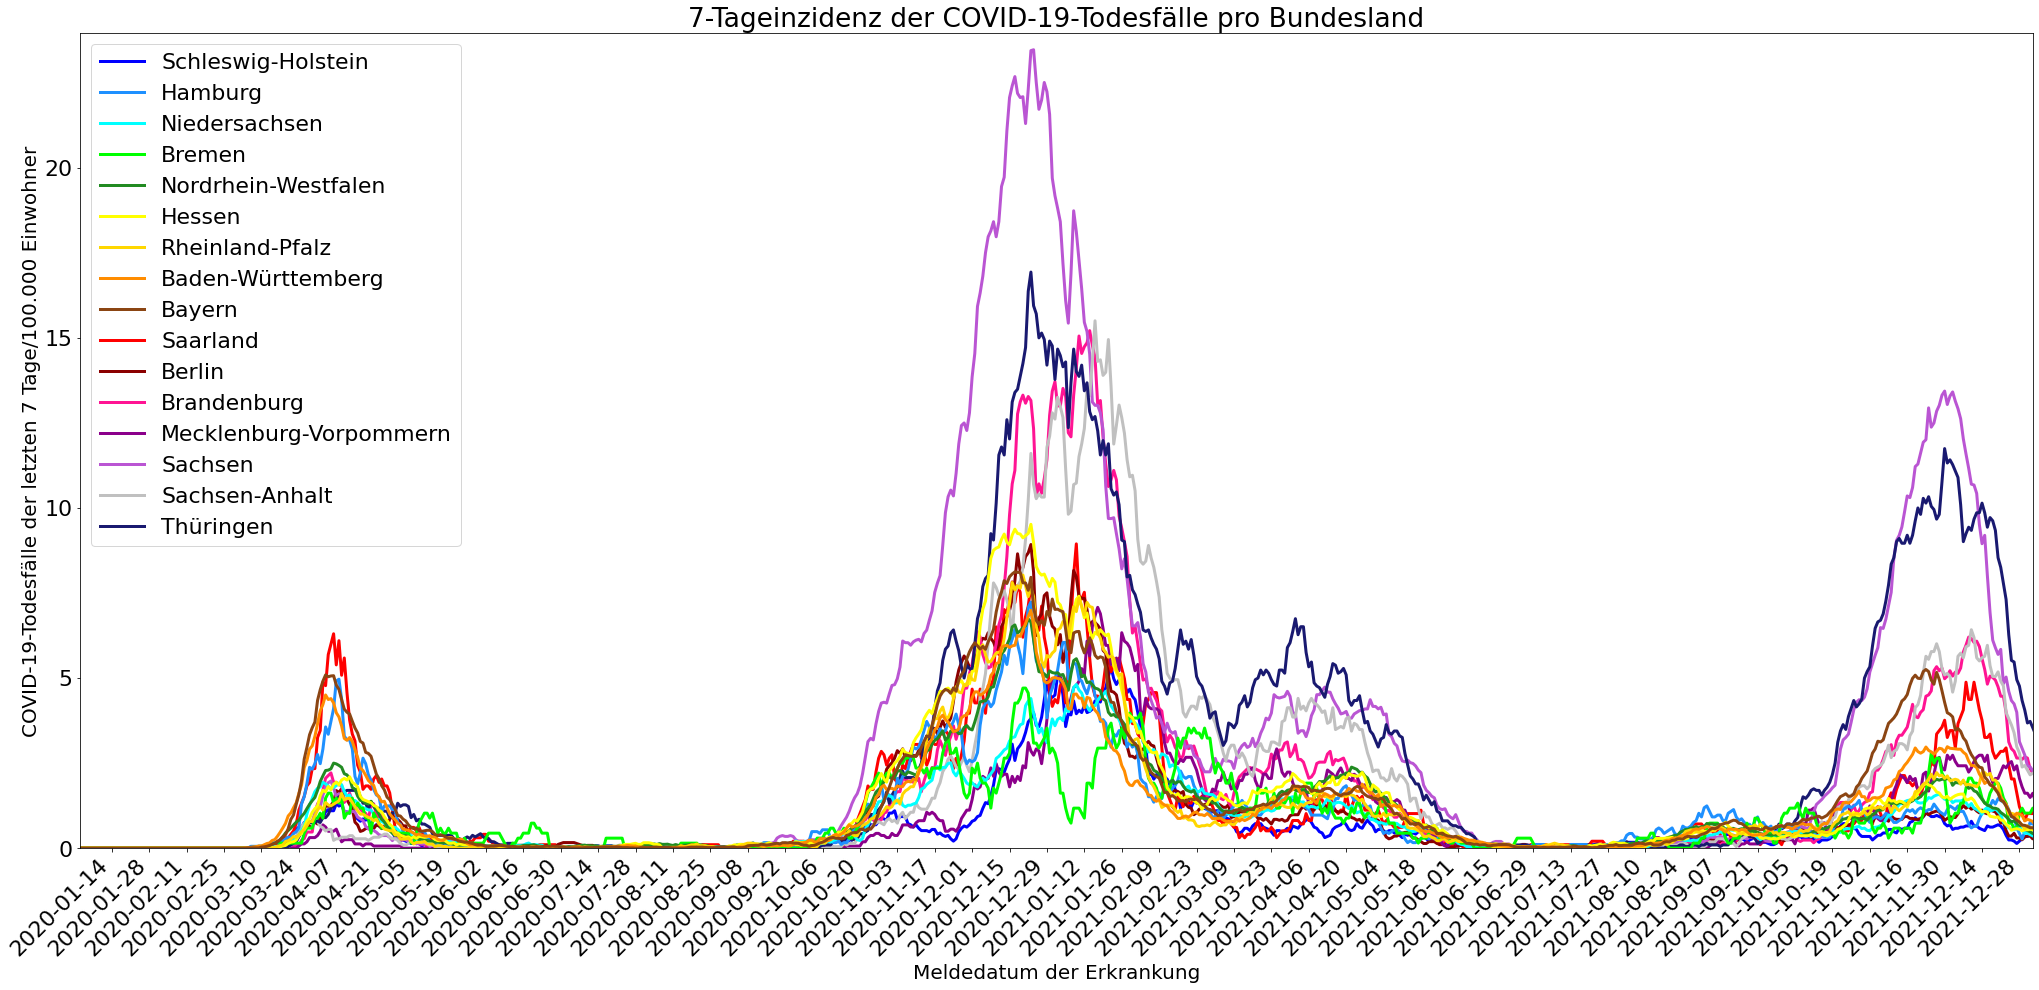

In [43]:
# Vorbereitung
col = {'01':'blue', '02':'dodgerblue', '03':'cyan', '04':'lime', '05':'forestgreen', '06':'yellow', '07':'gold', '08':'darkorange', '09':'saddlebrown', '10':'red', '11':'darkred', '12':'deeppink', '13':'darkmagenta', '14':'mediumorchid', '15':'silver', '16':'midnightblue'}
fig, ax = plt.subplots(figsize=(35,15))
y_max = max(data_bl['TodesfaelleEWZ_7'])
x_min = min(data_bl['Meldedatum'])
x_max = datetime.strptime("02/01/22", '%d/%m/%y')

# Daten
for bl in bl_id['BL_ID_str']:
    plt.plot( data_bl.loc[data_bl['IdBundesland_str'] == bl]['Meldedatum'], data_bl.loc[data_bl['IdBundesland_str'] == bl]['TodesfaelleEWZ_7'], color=col[bl], linewidth=3, label=bl_id.loc[bl_id['BL_ID_str'] == bl]['BL'].item())

# Einstellungen
plt.legend(loc='upper left')
plt.xlabel("Meldedatum der Erkrankung")
plt.ylabel("COVID-19-Todesfälle der letzten 7 Tage/100.000 Einwohner")
plt.title("7-Tageinzidenz der COVID-19-Todesfälle pro Bundesland")
plt.xlim([x_min, x_max])
plt.ylim([0, y_max+0.5])
plt.xticks(rotation=45, ha='right')

ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))

handles, labels = plt.gca().get_legend_handles_labels()
order = [0,8,9,10,11,12,13,14,15,1,2,3,4,5,6,7]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

plt.savefig('VerlaufTodesfaelle.pdf')  

#### Diagramm Genesene

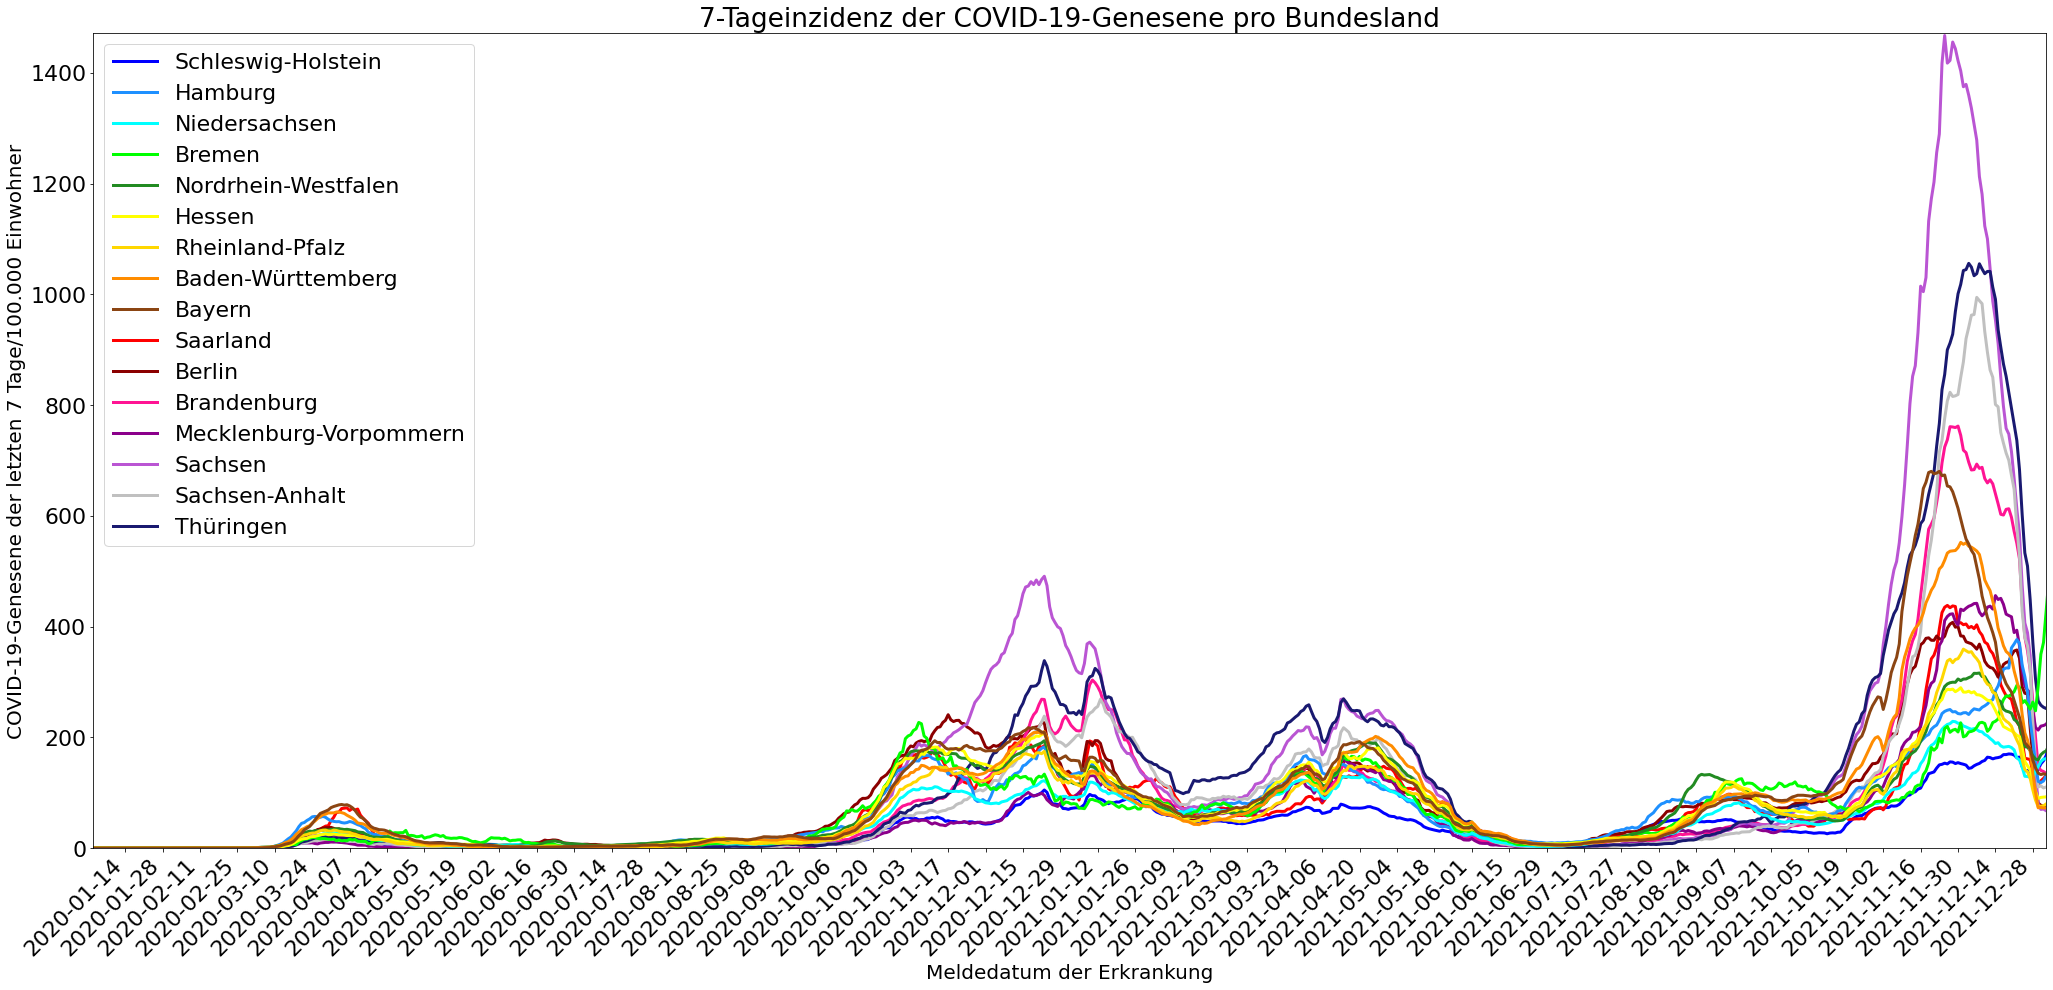

In [44]:
# Vorbereitung
col = {'01':'blue', '02':'dodgerblue', '03':'cyan', '04':'lime', '05':'forestgreen', '06':'yellow', '07':'gold', '08':'darkorange', '09':'saddlebrown', '10':'red', '11':'darkred', '12':'deeppink', '13':'darkmagenta', '14':'mediumorchid', '15':'silver', '16':'midnightblue'}
fig, ax = plt.subplots(figsize=(35,15))
y_max = max(data_bl['GeneseneEWZ_7'])
x_min = min(data_bl['Meldedatum'])
x_max = datetime.strptime("02/01/22", '%d/%m/%y')

# Daten
for bl in bl_id['BL_ID_str']:
    plt.plot( data_bl.loc[data_bl['IdBundesland_str'] == bl]['Meldedatum'], data_bl.loc[data_bl['IdBundesland_str'] == bl]['GeneseneEWZ_7'], color=col[bl], linewidth=3, label=bl_id.loc[bl_id['BL_ID_str'] == bl]['BL'].item())

# Einstellungen
plt.legend(loc='upper left')
plt.xlabel("Meldedatum der Erkrankung")
plt.ylabel("COVID-19-Genesene der letzten 7 Tage/100.000 Einwohner")
plt.title("7-Tageinzidenz der COVID-19-Genesene pro Bundesland")
plt.xlim([x_min, x_max])
plt.ylim([0, y_max+5])
plt.xticks(rotation=45, ha='right')

ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))

handles, labels = plt.gca().get_legend_handles_labels()
order = [0,8,9,10,11,12,13,14,15,1,2,3,4,5,6,7]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order]) 

plt.savefig('VerlaufGenesene.pdf')  

### Kartendarstellung der 7-Tage-Inzidenz <a class="anchor" id="analyse-map"></a>

Die 7-Tageinzidenz soll für alle vier Wellenhochpunkte dargestellt werden.

- 1. Welle: 16.03.2020
- 2. Welle: 16.12.2020
- 3. Welle: 21.04.2021
- 4. Welle: 24.11.2021

#### Maximum 1. Welle (16.03.2020)

Zunächst müssen die Daten für den Hochpunkt der 1. Welle am 16.03.2020 herausgefiltert und mit den Geometriedaten verknüpft werden.

In [45]:
data_Max1W = data_ewz.loc[data_ewz['Meldedatum']=='2020-03-16']
data_Max1W.head()

,AGS,EWZ,EWZ_BL,IdBundesland,Bundesland,IdLandkreis,Landkreis,Meldedatum,AnzahlFall,AnzahlTodesfall,AnzahlGenesen,IdLandkreis_str,FaelleEWZ,TodesfaelleEWZ,GeneseneEWZ,FaelleEWZ_7,TodesfaelleEWZ_7,GeneseneEWZ_7
74,01001,89934,2910875,1,Schleswig-Holstein,1001,SK Flensburg,2020-03-16,0,0,0,01001,0.000000,0.0,0.000000,4.447706,0.0,4.447706
823,01002,246601,2910875,1,Schleswig-Holstein,1002,SK Kiel,2020-03-16,5,0,5,01002,2.027567,0.0,2.027567,7.299240,0.0,7.299240
1572,01003,215846,2910875,1,Schleswig-Holstein,1003,SK Lübeck,2020-03-16,0,0,0,01003,0.000000,0.0,0.000000,3.706346,0.0,3.706346
2321,01004,79905,2910875,1,Schleswig-Holstein,1004,SK Neumünster,2020-03-16,1,0,1,01004,1.251486,0.0,1.251486,1.251486,0.0,1.251486
3070,01051,133251,2910875,1,Schleswig-Holstein,1051,LK Dithmarschen,2020-03-16,0,0,0,01051,0.000000,0.0,0.000000,3.752317,0.0,3.752317


In [46]:
data_Max1W_Geom = pd.merge(data_Max1W, kreise_geom, left_on="IdLandkreis_str", right_on="AGS", how='right')
data_Max1W_Geom.head()

,AGS_x,EWZ,EWZ_BL,IdBundesland,Bundesland,IdLandkreis,Landkreis,Meldedatum,AnzahlFall,AnzahlTodesfall,...,TodesfaelleEWZ,GeneseneEWZ,FaelleEWZ_7,TodesfaelleEWZ_7,GeneseneEWZ_7,AGS_y,SHAPE,Shape__Area,Shape__Length,AGS_int
0,01001,89934,2910875,1,Schleswig-Holstein,1001,SK Flensburg,2020-03-16,0,0,...,0.0,0.000000,4.447706,0.0,4.447706,01001,"{'rings': [[[526513.752884256, 6075133.4118775...",4.918293e+07,42752.592015,1001
1,01002,246601,2910875,1,Schleswig-Holstein,1002,SK Kiel,2020-03-16,5,0,...,0.0,2.027567,7.299240,0.0,7.299240,01002,"{'rings': [[[575841.569494392, 6032148.0317960...",1.122314e+08,104373.457289,1002
2,01003,215846,2910875,1,Schleswig-Holstein,1003,SK Lübeck,2020-03-16,0,0,...,0.0,0.000000,3.706346,0.0,3.706346,01003,"{'rings': [[[623056.150596513, 5983746.4452249...",2.116771e+08,146459.457897,1003
3,01004,79905,2910875,1,Schleswig-Holstein,1004,SK Neumünster,2020-03-16,1,0,...,0.0,1.251486,1.251486,0.0,1.251486,01004,"{'rings': [[[565015.651588687, 6000637.5134813...",7.140224e+07,54863.995416,1004
4,01051,133251,2910875,1,Schleswig-Holstein,1051,LK Dithmarschen,2020-03-16,0,0,...,0.0,0.000000,3.752317,0.0,3.752317,01051,"{'rings': [[[479877.791292057, 5990290.5867080...",1.425511e+09,250768.570200,1051


Um die Daten darstellen zu können muss ein Layer in dem Projektordner erzeugt werden. Damit nicht zu viele Layer mit der Zeit angelegt werden wird ein möglicher zuvor erstellter Layer gelöscht.

In [47]:
gis = GIS("home")
items = gis.content.search(query ='Corona-7Tageinzidenz1W')
for item in items:
    item.delete()
data_Max1W_fl = data_Max1W_Geom.spatial.to_featurelayer('Corona-7Tageinzidenz1W', tags=['Corona', 'COVID-19'], folder='Masterprojekt')

Dieser Layer kann nun in einer Karte angezeigt werden.

In [48]:
gis = GIS(url="https://arcgis.services.fbbgg.hs-woe.de/arcgis")
map_Max1W = gis.map("Germany")
classed_color_renderer =  {"renderer":"ClassedColorRenderer", "field_name":"faelle_ewz_7" }
map_Max1W.add_layer(data_Max1W_fl, classed_color_renderer)
map_Max1W

MapView(layout=Layout(height='400px', width='100%'))

#### Maximum 2. Welle (16.12.2020)

Zunächst müssen die Daten für den Hochpunkt der 2. Welle am 16.12.2020 herausgefiltert und mit den Geometriedaten verknüpft werden.

In [49]:
data_Max2W = data_ewz.loc[data_ewz['Meldedatum']=='2020-12-16']
data_Max2W.head()

,AGS,EWZ,EWZ_BL,IdBundesland,Bundesland,IdLandkreis,Landkreis,Meldedatum,AnzahlFall,AnzahlTodesfall,AnzahlGenesen,IdLandkreis_str,FaelleEWZ,TodesfaelleEWZ,GeneseneEWZ,FaelleEWZ_7,TodesfaelleEWZ_7,GeneseneEWZ_7
349,01001,89934,2910875,1,Schleswig-Holstein,1001,SK Flensburg,2020-12-16,6,0,6,01001,6.671559,0.000000,6.671559,53.372473,4.447706,48.924767
1098,01002,246601,2910875,1,Schleswig-Holstein,1002,SK Kiel,2020-12-16,65,0,65,01002,26.358368,0.000000,26.358368,115.571307,2.027567,113.543741
1847,01003,215846,2910875,1,Schleswig-Holstein,1003,SK Lübeck,2020-12-16,59,0,59,01003,27.334303,0.000000,27.334303,188.097069,2.316466,185.780603
2596,01004,79905,2910875,1,Schleswig-Holstein,1004,SK Neumünster,2020-12-16,5,0,5,01004,6.257431,0.000000,6.257431,60.071335,1.251486,58.819849
3345,01051,133251,2910875,1,Schleswig-Holstein,1051,LK Dithmarschen,2020-12-16,10,1,9,01051,7.504634,0.750463,6.754171,63.789390,0.750463,63.038927


In [50]:
data_Max2W_Geom = pd.merge(data_Max2W, kreise_geom, left_on="IdLandkreis_str", right_on="AGS", how='right')
data_Max2W_Geom.head()

,AGS_x,EWZ,EWZ_BL,IdBundesland,Bundesland,IdLandkreis,Landkreis,Meldedatum,AnzahlFall,AnzahlTodesfall,...,TodesfaelleEWZ,GeneseneEWZ,FaelleEWZ_7,TodesfaelleEWZ_7,GeneseneEWZ_7,AGS_y,SHAPE,Shape__Area,Shape__Length,AGS_int
0,01001,89934,2910875,1,Schleswig-Holstein,1001,SK Flensburg,2020-12-16,6,0,...,0.000000,6.671559,53.372473,4.447706,48.924767,01001,"{'rings': [[[526513.752884256, 6075133.4118775...",4.918293e+07,42752.592015,1001
1,01002,246601,2910875,1,Schleswig-Holstein,1002,SK Kiel,2020-12-16,65,0,...,0.000000,26.358368,115.571307,2.027567,113.543741,01002,"{'rings': [[[575841.569494392, 6032148.0317960...",1.122314e+08,104373.457289,1002
2,01003,215846,2910875,1,Schleswig-Holstein,1003,SK Lübeck,2020-12-16,59,0,...,0.000000,27.334303,188.097069,2.316466,185.780603,01003,"{'rings': [[[623056.150596513, 5983746.4452249...",2.116771e+08,146459.457897,1003
3,01004,79905,2910875,1,Schleswig-Holstein,1004,SK Neumünster,2020-12-16,5,0,...,0.000000,6.257431,60.071335,1.251486,58.819849,01004,"{'rings': [[[565015.651588687, 6000637.5134813...",7.140224e+07,54863.995416,1004
4,01051,133251,2910875,1,Schleswig-Holstein,1051,LK Dithmarschen,2020-12-16,10,1,...,0.750463,6.754171,63.789390,0.750463,63.038927,01051,"{'rings': [[[479877.791292057, 5990290.5867080...",1.425511e+09,250768.570200,1051


Um die Daten darstellen zu können muss ein Layer in dem Projektordner erzeugt werden. Damit nicht zu viele Layer mit der Zeit angelegt werden wird ein möglicher zuvor erstellter Layer gelöscht.

In [51]:
gis = GIS("home")
items = gis.content.search(query ='Corona-7Tageinzidenz2W')
for item in items:
    item.delete()
data_Max2W_fl = data_Max2W_Geom.spatial.to_featurelayer('Corona-7Tageinzidenz2W', tags=['Corona', 'COVID-19'], folder='Masterprojekt')

Dieser Layer kann nun in einer Karte angezeigt werden.

In [52]:
gis = GIS(url="https://arcgis.services.fbbgg.hs-woe.de/arcgis")
map_Max2W = gis.map("Germany")
classed_color_renderer =  {"renderer":"ClassedColorRenderer", "field_name":"faelle_ewz_7" }
map_Max2W.add_layer(data_Max2W_fl, classed_color_renderer)
map_Max2W

MapView(layout=Layout(height='400px', width='100%'))

#### Maximum 3. Welle (21.04.2021)

Zunächst müssen die Daten für den Hochpunkt der 2. Welle am 21.04.2021 herausgefiltert und mit den Geometriedaten verknüpft werden.

In [53]:
data_Max3W = data_ewz.loc[data_ewz['Meldedatum']=='2021-04-21']
data_Max3W.head()

,AGS,EWZ,EWZ_BL,IdBundesland,Bundesland,IdLandkreis,Landkreis,Meldedatum,AnzahlFall,AnzahlTodesfall,AnzahlGenesen,IdLandkreis_str,FaelleEWZ,TodesfaelleEWZ,GeneseneEWZ,FaelleEWZ_7,TodesfaelleEWZ_7,GeneseneEWZ_7
475,01001,89934,2910875,1,Schleswig-Holstein,1001,SK Flensburg,2021-04-21,10,0,10,01001,11.119265,0.0,11.119265,50.036694,0.0,50.036694
1224,01002,246601,2910875,1,Schleswig-Holstein,1002,SK Kiel,2021-04-21,35,0,35,01002,14.192968,0.0,14.192968,81.913699,0.0,81.913699
1973,01003,215846,2910875,1,Schleswig-Holstein,1003,SK Lübeck,2021-04-21,14,0,14,01003,6.486106,0.0,6.486106,62.544592,0.0,62.544592
2722,01004,79905,2910875,1,Schleswig-Holstein,1004,SK Neumünster,2021-04-21,2,0,2,01004,2.502972,0.0,2.502972,53.813904,0.0,53.813904
3471,01051,133251,2910875,1,Schleswig-Holstein,1051,LK Dithmarschen,2021-04-21,24,0,24,01051,18.011122,0.0,18.011122,68.292170,0.0,68.292170


In [54]:
data_Max3W_Geom = pd.merge(data_Max3W, kreise_geom, left_on="IdLandkreis_str", right_on="AGS", how='right')
data_Max3W_Geom.head()

,AGS_x,EWZ,EWZ_BL,IdBundesland,Bundesland,IdLandkreis,Landkreis,Meldedatum,AnzahlFall,AnzahlTodesfall,...,TodesfaelleEWZ,GeneseneEWZ,FaelleEWZ_7,TodesfaelleEWZ_7,GeneseneEWZ_7,AGS_y,SHAPE,Shape__Area,Shape__Length,AGS_int
0,01001,89934,2910875,1,Schleswig-Holstein,1001,SK Flensburg,2021-04-21,10,0,...,0.0,11.119265,50.036694,0.0,50.036694,01001,"{'rings': [[[526513.752884256, 6075133.4118775...",4.918293e+07,42752.592015,1001
1,01002,246601,2910875,1,Schleswig-Holstein,1002,SK Kiel,2021-04-21,35,0,...,0.0,14.192968,81.913699,0.0,81.913699,01002,"{'rings': [[[575841.569494392, 6032148.0317960...",1.122314e+08,104373.457289,1002
2,01003,215846,2910875,1,Schleswig-Holstein,1003,SK Lübeck,2021-04-21,14,0,...,0.0,6.486106,62.544592,0.0,62.544592,01003,"{'rings': [[[623056.150596513, 5983746.4452249...",2.116771e+08,146459.457897,1003
3,01004,79905,2910875,1,Schleswig-Holstein,1004,SK Neumünster,2021-04-21,2,0,...,0.0,2.502972,53.813904,0.0,53.813904,01004,"{'rings': [[[565015.651588687, 6000637.5134813...",7.140224e+07,54863.995416,1004
4,01051,133251,2910875,1,Schleswig-Holstein,1051,LK Dithmarschen,2021-04-21,24,0,...,0.0,18.011122,68.292170,0.0,68.292170,01051,"{'rings': [[[479877.791292057, 5990290.5867080...",1.425511e+09,250768.570200,1051


Um die Daten darstellen zu können muss ein Layer in dem Projektordner erzeugt werden. Damit nicht zu viele Layer mit der Zeit angelegt werden wird ein möglicher zuvor erstellter Layer gelöscht.

In [55]:
gis = GIS("home")
items = gis.content.search(query ='Corona-7Tageinzidenz3W')
for item in items:
    item.delete()
data_Max3W_fl = data_Max3W_Geom.spatial.to_featurelayer('Corona-7Tageinzidenz3W', tags=['Corona', 'COVID-19'], folder='Masterprojekt')

Dieser Layer kann nun in einer Karte angezeigt werden.

In [56]:
gis = GIS(url="https://arcgis.services.fbbgg.hs-woe.de/arcgis")
map_Max3W = gis.map("Germany")
classed_color_renderer =  {"renderer":"ClassedColorRenderer", "field_name":"faelle_ewz_7" }
map_Max3W.add_layer(data_Max3W_fl, classed_color_renderer)
map_Max3W

MapView(layout=Layout(height='400px', width='100%'))

#### Maximum 4. Welle (24.11.2021)

Zunächst müssen die Daten für den Hochpunkt der 4. Welle am 24.11.2021 herausgefiltert und mit den Geometriedaten verknüpft werden.

In [57]:
data_Max4W = data_ewz.loc[data_ewz['Meldedatum']=='2021-11-24']
data_Max4W.head()

,AGS,EWZ,EWZ_BL,IdBundesland,Bundesland,IdLandkreis,Landkreis,Meldedatum,AnzahlFall,AnzahlTodesfall,AnzahlGenesen,IdLandkreis_str,FaelleEWZ,TodesfaelleEWZ,GeneseneEWZ,FaelleEWZ_7,TodesfaelleEWZ_7,GeneseneEWZ_7
692,01001,89934,2910875,1,Schleswig-Holstein,1001,SK Flensburg,2021-11-24,24,0,24,01001,26.686237,0.0,26.686237,150.110081,4.447706,145.662375
1441,01002,246601,2910875,1,Schleswig-Holstein,1002,SK Kiel,2021-11-24,73,0,73,01002,29.602475,0.0,29.602475,140.307622,0.405513,139.902109
2190,01003,215846,2910875,1,Schleswig-Holstein,1003,SK Lübeck,2021-11-24,79,0,79,01003,36.600169,0.0,36.600169,166.785579,0.463293,166.322285
2939,01004,79905,2910875,1,Schleswig-Holstein,1004,SK Neumünster,2021-11-24,42,0,42,01004,52.562418,0.0,52.562418,202.740755,1.251486,201.489269
3688,01051,133251,2910875,1,Schleswig-Holstein,1051,LK Dithmarschen,2021-11-24,19,0,19,01051,14.258805,0.0,14.258805,93.807926,0.000000,93.807926


In [58]:
data_Max4W_Geom = pd.merge(data_Max4W, kreise_geom, left_on="IdLandkreis_str", right_on="AGS", how='right')
data_Max4W_Geom.head()

,AGS_x,EWZ,EWZ_BL,IdBundesland,Bundesland,IdLandkreis,Landkreis,Meldedatum,AnzahlFall,AnzahlTodesfall,...,TodesfaelleEWZ,GeneseneEWZ,FaelleEWZ_7,TodesfaelleEWZ_7,GeneseneEWZ_7,AGS_y,SHAPE,Shape__Area,Shape__Length,AGS_int
0,01001,89934,2910875,1,Schleswig-Holstein,1001,SK Flensburg,2021-11-24,24,0,...,0.0,26.686237,150.110081,4.447706,145.662375,01001,"{'rings': [[[526513.752884256, 6075133.4118775...",4.918293e+07,42752.592015,1001
1,01002,246601,2910875,1,Schleswig-Holstein,1002,SK Kiel,2021-11-24,73,0,...,0.0,29.602475,140.307622,0.405513,139.902109,01002,"{'rings': [[[575841.569494392, 6032148.0317960...",1.122314e+08,104373.457289,1002
2,01003,215846,2910875,1,Schleswig-Holstein,1003,SK Lübeck,2021-11-24,79,0,...,0.0,36.600169,166.785579,0.463293,166.322285,01003,"{'rings': [[[623056.150596513, 5983746.4452249...",2.116771e+08,146459.457897,1003
3,01004,79905,2910875,1,Schleswig-Holstein,1004,SK Neumünster,2021-11-24,42,0,...,0.0,52.562418,202.740755,1.251486,201.489269,01004,"{'rings': [[[565015.651588687, 6000637.5134813...",7.140224e+07,54863.995416,1004
4,01051,133251,2910875,1,Schleswig-Holstein,1051,LK Dithmarschen,2021-11-24,19,0,...,0.0,14.258805,93.807926,0.000000,93.807926,01051,"{'rings': [[[479877.791292057, 5990290.5867080...",1.425511e+09,250768.570200,1051


Um die Daten darstellen zu können muss ein Layer in dem Projektordner erzeugt werden. Damit nicht zu viele Layer mit der Zeit angelegt werden wird ein möglicher zuvor erstellter Layer gelöscht.

In [59]:
gis = GIS("home")
items = gis.content.search(query ='Corona-7Tageinzidenz4W')
for item in items:
    item.delete()
data_Max4W_fl = data_Max4W_Geom.spatial.to_featurelayer('Corona-7Tageinzidenz4W', tags=['Corona', 'COVID-19'], folder='Masterprojekt')

Dieser Layer kann nun in einer Karte angezeigt werden.

In [60]:
gis = GIS(url="https://arcgis.services.fbbgg.hs-woe.de/arcgis")
map_Max4W = gis.map("Germany")
classed_color_renderer =  {"renderer":"ClassedColorRenderer", "field_name":"faelle_ewz_7" }
map_Max4W.add_layer(data_Max4W_fl, classed_color_renderer)
map_Max4W

MapView(layout=Layout(height='400px', width='100%'))

### HotSpot-Analyse <a class="anchor" id="analyse-hsa"></a>

Es soll eine Hot Spot-Analyse für alle vier Wellenhochpunkte durchgeführt werden.

- 1. Welle: 16.03.2020
- 2. Welle: 16.12.2020
- 3. Welle: 21.04.2021
- 4. Welle: 24.11.2021

Eine Erklärung des Werkzeugs von ArcGIS ist unter diesem Link zu finden:
https://developers.arcgis.com/python/api-reference/arcgis.features.analyze_patterns.html#find-hot-spots

#### Maximum 1. Welle (16.03.2020)

Auch hier wird bei der Analyse ein Layer erzeugt. Damit nicht zu viele Layer mit der Zeit angelegt werden wird ein möglicher zuvor erstellter Layer gelöscht.

Nach der Durchführung der Hot Spot-Analyse über **arcgis.features.analyze_patterns.find_hot_spots()** wird der Ergebnislayer noch in den Projektordner verschoben.

In [61]:
gis = GIS("home")
items = gis.content.search(query ='HotSpot_1W')
for item in items:
    item.delete()
hotspot_1W = arcgis.features.analyze_patterns.find_hot_spots(data_Max1W_fl, analysis_field="faelle_ewz_7", output_name="HotSpot_1W", distance_band=None, distance_band_unit=None)
hotspot_1W.move('Masterprojekt')

{'success': True,
 'itemId': 'ee8798280ab24aa0a1fd86222011089f',
 'owner': 'ni2758',
 'folder': '352ee0cfa24142e5acf961c3c4dbd256'}

Dieser Layer kann nun in einer Karte angezeigt werden.

In [62]:
gis = GIS(url="https://arcgis.services.fbbgg.hs-woe.de/arcgis")
map_HS_1W = gis.map("Germany")
map_HS_1W.add_layer(hotspot_1W)
map_HS_1W

MapView(layout=Layout(height='400px', width='100%'))

#### Maximum 2. Welle (16.12.2020)

Auch hier wird bei der Analyse ein Layer erzeugt. Damit nicht zu viele Layer mit der Zeit angelegt werden wird ein möglicher zuvor erstellter Layer gelöscht.

Nach der Durchführung der Hot Spot-Analyse über **arcgis.features.analyze_patterns.find_hot_spots()** wird der Ergebnislayer noch in den Projektordner verschoben.

In [63]:
gis = GIS("home")
items = gis.content.search(query ='HotSpot_2W')
for item in items:
    item.delete()
hotspot_2W = arcgis.features.analyze_patterns.find_hot_spots(data_Max2W_fl, analysis_field="faelle_ewz_7", output_name="HotSpot_2W", distance_band=None, distance_band_unit=None)
hotspot_2W.move('Masterprojekt')

{'success': True,
 'itemId': '007a0ce24ac941039dc0d7abfdeba27e',
 'owner': 'ni2758',
 'folder': '352ee0cfa24142e5acf961c3c4dbd256'}

Dieser Layer kann nun in einer Karte angezeigt werden.

In [64]:
gis = GIS(url="https://arcgis.services.fbbgg.hs-woe.de/arcgis")
map_HS_2W = gis.map("Germany")
map_HS_2W.add_layer(hotspot_2W)
map_HS_2W

MapView(layout=Layout(height='400px', width='100%'))

#### Maximum 3. Welle (21.04.2021)

Auch hier wird bei der Analyse ein Layer erzeugt. Damit nicht zu viele Layer mit der Zeit angelegt werden wird ein möglicher zuvor erstellter Layer gelöscht.

Nach der Durchführung der Hot Spot-Analyse über **arcgis.features.analyze_patterns.find_hot_spots()** wird der Ergebnislayer noch in den Projektordner verschoben.

In [65]:
gis = GIS("home")
items = gis.content.search(query ='HotSpot_3W')
for item in items:
    item.delete()
hotspot_3W = arcgis.features.analyze_patterns.find_hot_spots(data_Max3W_fl, analysis_field="faelle_ewz_7", output_name="HotSpot_3W", distance_band=None, distance_band_unit=None)
hotspot_3W.move('Masterprojekt')

{'success': True,
 'itemId': '6e4db6699f774e9abe2cf405aa26ae5f',
 'owner': 'ni2758',
 'folder': '352ee0cfa24142e5acf961c3c4dbd256'}

Dieser Layer kann nun in einer Karte angezeigt werden.

In [66]:
gis = GIS(url="https://arcgis.services.fbbgg.hs-woe.de/arcgis")
map_HS_3W = gis.map("Germany")
map_HS_3W.add_layer(hotspot_3W)
map_HS_3W

MapView(layout=Layout(height='400px', width='100%'))

#### Maximum 4. Welle (24.11.2021)

Auch hier wird bei der Analyse ein Layer erzeugt. Damit nicht zu viele Layer mit der Zeit angelegt werden wird ein möglicher zuvor erstellter Layer gelöscht.

Nach der Durchführung der Hot Spot-Analyse über **arcgis.features.analyze_patterns.find_hot_spots()** wird der Ergebnislayer noch in den Projektordner verschoben.

In [67]:
gis = GIS("home")
items = gis.content.search(query ='HotSpot_4W')
for item in items:
    item.delete()
hotspot_4W = arcgis.features.analyze_patterns.find_hot_spots(data_Max4W_fl, analysis_field="faelle_ewz_7", output_name="HotSpot_4W", distance_band=None, distance_band_unit=None)
hotspot_4W.move('Masterprojekt')

{'success': True,
 'itemId': '389537c2ce774f75a36dfbd804043182',
 'owner': 'ni2758',
 'folder': '352ee0cfa24142e5acf961c3c4dbd256'}

Dieser Layer kann nun in einer Karte angezeigt werden.

In [68]:
gis = GIS(url="https://arcgis.services.fbbgg.hs-woe.de/arcgis")
map_HS_4W = gis.map("Germany")
map_HS_4W.add_layer(hotspot_4W)
map_HS_4W

MapView(layout=Layout(height='400px', width='100%'))

### Ausreißer-Analyse <a class="anchor" id="analyse-outlier"></a>

Es soll eine Ausreißer-Analyse für alle vier Wellenhochpunkte durchgeführt werden.

- 1. Welle: 16.03.2020
- 2. Welle: 16.12.2020
- 3. Welle: 21.04.2021
- 4. Welle: 24.11.2021

#### 1. Welle (16.03.2020)

Auch hier wird bei der Analyse ein Layer erzeugt. Damit nicht zu viele Layer mit der Zeit angelegt werden wird ein möglicher zuvor erstellter Layer gelöscht.

Nach der Durchführung der Ausreißer-Analyse über **arcgis.features.analyze_patterns.find_outliers()** wird der Ergebnislayer noch in den Projektordner verschoben.

In [69]:
gis = GIS("home")
items = gis.content.search(query ='Outliers_1W')
for item in items:
    item.delete()
outliers_1W_Res = arcgis.features.analyze_patterns.find_outliers(data_Max1W_fl, analysis_field="faelle_ewz_7", output_name="Outliers_1W")
outliers_1W = outliers_1W_Res['outliers_result_layer']
outliers_1W.move('Masterprojekt')

{'success': True,
 'itemId': 'a5d1c99eeb01408ebf6f8d78a3bc5b15',
 'owner': 'ni2758',
 'folder': '352ee0cfa24142e5acf961c3c4dbd256'}

Dieser Layer kann nun in einer Karte angezeigt werden.

In [70]:
gis = GIS(url="https://arcgis.services.fbbgg.hs-woe.de/arcgis")
map_Out_1W = gis.map("Germany")
map_Out_1W.add_layer(outliers_1W)
map_Out_1W

MapView(layout=Layout(height='400px', width='100%'))

#### 2. Welle (16.12.2020)

Auch hier wird bei der Analyse ein Layer erzeugt. Damit nicht zu viele Layer mit der Zeit angelegt werden wird ein möglicher zuvor erstellter Layer gelöscht.

Nach der Durchführung der Ausreißer-Analyse über **arcgis.features.analyze_patterns.find_outliers()** wird der Ergebnislayer noch in den Projektordner verschoben.

In [71]:
gis = GIS("home")
items = gis.content.search(query ='Outliers_2W')
for item in items:
    item.delete()
outliers_2W_Res = arcgis.features.analyze_patterns.find_outliers(data_Max2W_fl, analysis_field="faelle_ewz_7", output_name="Outliers_2W")
outliers_2W = outliers_2W_Res['outliers_result_layer']
outliers_2W.move('Masterprojekt')

{'success': True,
 'itemId': '79fa7d71c6064d5eb70efd07251c3e34',
 'owner': 'ni2758',
 'folder': '352ee0cfa24142e5acf961c3c4dbd256'}

Dieser Layer kann nun in einer Karte angezeigt werden.

In [72]:
gis = GIS(url="https://arcgis.services.fbbgg.hs-woe.de/arcgis")
map_Out_2W = gis.map("Germany")
map_Out_2W.add_layer(outliers_2W)
map_Out_2W

MapView(layout=Layout(height='400px', width='100%'))

#### 3. Welle (21.04.2021)

Auch hier wird bei der Analyse ein Layer erzeugt. Damit nicht zu viele Layer mit der Zeit angelegt werden wird ein möglicher zuvor erstellter Layer gelöscht.

Nach der Durchführung der Ausreißer-Analyse über **arcgis.features.analyze_patterns.find_outliers()** wird der Ergebnislayer noch in den Projektordner verschoben.

In [73]:
gis = GIS("home")
items = gis.content.search(query ='Outliers_3W')
for item in items:
    item.delete()
outliers_3W_Res = arcgis.features.analyze_patterns.find_outliers(data_Max3W_fl, analysis_field="faelle_ewz_7", output_name="Outliers_3W")
outliers_3W = outliers_3W_Res['outliers_result_layer']
outliers_3W.move('Masterprojekt')

{'success': True,
 'itemId': '34d4cde5e9614bd2a7c564e66c87fb86',
 'owner': 'ni2758',
 'folder': '352ee0cfa24142e5acf961c3c4dbd256'}

Dieser Layer kann nun in einer Karte angezeigt werden.

In [74]:
gis = GIS(url="https://arcgis.services.fbbgg.hs-woe.de/arcgis")
map_Out_3W = gis.map("Germany")
map_Out_3W.add_layer(outliers_3W)
map_Out_3W

MapView(layout=Layout(height='400px', width='100%'))

#### 4. Welle (24.11.2021)

Auch hier wird bei der Analyse ein Layer erzeugt. Damit nicht zu viele Layer mit der Zeit angelegt werden wird ein möglicher zuvor erstellter Layer gelöscht.

Nach der Durchführung der Ausreißer-Analyse über **arcgis.features.analyze_patterns.find_outliers()** wird der Ergebnislayer noch in den Projektordner verschoben.

In [75]:
gis = GIS("home")
items = gis.content.search(query ='Outliers_4W')
for item in items:
    item.delete()
outliers_4W_Res = arcgis.features.analyze_patterns.find_outliers(data_Max4W_fl, analysis_field="faelle_ewz_7", output_name="Outliers_4W")
outliers_4W = outliers_4W_Res['outliers_result_layer']
outliers_4W.move('Masterprojekt')

{'success': True,
 'itemId': '22853fc19fb34390b493a1448b67da59',
 'owner': 'ni2758',
 'folder': '352ee0cfa24142e5acf961c3c4dbd256'}

Dieser Layer kann nun in einer Karte angezeigt werden.

In [76]:
gis = GIS(url="https://arcgis.services.fbbgg.hs-woe.de/arcgis")
map_Out_4W = gis.map("Germany")
map_Out_4W.add_layer(outliers_4W)
map_Out_4W

MapView(layout=Layout(height='400px', width='100%'))

### Space-Time Cubes <a class="anchor" id="analyse-stc"></a>

Es sollen Space-Time Cubes für alle vier Wellen durchgeführt werden.

- 1. Welle: 02.03.2020 - 19.04.2020
- 2. Welle: 05.10.2020 - 31.01.2021
- 3. Welle: 01.03.2021 - 16.05.2021
- 4. Welle: 04.10.2021 - 02.01.2022

Dabei werden arcpy-Funktionen verwendet. Dafür müssen die Kreisgeometrien zunächst in der Geodatabase abgespeichert werden.

In [77]:
path_geom = os.path.join(results_dir, 'kreise_geom')
kreise_geom.spatial.to_featureclass(path_geom)

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



'/arcgis/home/Results.gdb/kreise_geom'

#### Space Time Cubes berechnen <a class="anchor" id="analyse-stc-create"></a>

Die Funktionsweise der Space-Time Cubes kann unter folgenden Link nachvollzogen werden: 
https://pro.arcgis.com/de/pro-app/latest/tool-reference/space-time-pattern-mining/createcubefromdefinedlocations.htm

##### kleine Datenmenge (10.12.2020 - 24.12.2020)

Testweise wurden der Space-Time Cube für eine kleiner Datenmenge von zwei Wochen (10.12.2020 - 24.12.2020) durchgeführt. Dieser Zeitraum muss aus den Daten extrahiert und ebenfalls in der Geodatabase als Tabelle abgespeichert werden.

In [78]:
data_stc_test = data_ewz.loc[(data_ewz['Meldedatum']>='2020-12-10') & (data_ewz['Meldedatum']<='2020-12-24')]
data_stc_test

,AGS,EWZ,EWZ_BL,IdBundesland,Bundesland,IdLandkreis,Landkreis,Meldedatum,AnzahlFall,AnzahlTodesfall,AnzahlGenesen,IdLandkreis_str,FaelleEWZ,TodesfaelleEWZ,GeneseneEWZ,FaelleEWZ_7,TodesfaelleEWZ_7,GeneseneEWZ_7
343,01001,89934,2910875,1,Schleswig-Holstein,1001,SK Flensburg,2020-12-10,10,0,10,01001,11.119265,0.000000,11.119265,30.022016,0.000000,30.022016
344,01001,89934,2910875,1,Schleswig-Holstein,1001,SK Flensburg,2020-12-11,6,1,5,01001,6.671559,1.111927,5.559633,33.357796,1.111927,32.245869
345,01001,89934,2910875,1,Schleswig-Holstein,1001,SK Flensburg,2020-12-12,5,1,4,01001,5.559633,1.111927,4.447706,37.805502,2.223853,35.581649
346,01001,89934,2910875,1,Schleswig-Holstein,1001,SK Flensburg,2020-12-13,1,0,1,01001,1.111927,0.000000,1.111927,35.581649,2.223853,33.357796
347,01001,89934,2910875,1,Schleswig-Holstein,1001,SK Flensburg,2020-12-14,15,2,13,01001,16.678898,2.223853,14.455045,51.148620,4.447706,46.700914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307443,16077,88356,2120237,16,Thüringen,16077,LK Altenburger Land,2020-12-20,1,0,1,16077,1.131785,0.000000,1.131785,530.807189,13.581421,517.225768
307444,16077,88356,2120237,16,Thüringen,16077,LK Altenburger Land,2020-12-21,67,5,62,16077,75.829598,5.658925,70.170673,588.528227,18.108561,570.419666
307445,16077,88356,2120237,16,Thüringen,16077,LK Altenburger Land,2020-12-22,70,2,68,16077,79.224954,2.263570,76.961383,594.187152,16.976776,577.210376
307446,16077,88356,2120237,16,Thüringen,16077,LK Altenburger Land,2020-12-23,71,4,67,16077,80.356739,4.527140,75.829598,553.442890,18.108561,535.334329


In [79]:
path_test = os.path.join(results_dir, 'data_test')
data_stc_test.spatial.to_table(path_test)

'/arcgis/home/Results.gdb/data_test'

Falls der zu erstellende Space-Time Cube aus vorherigen Durchläufen bereits vorliegt wird dieser gelöscht.

Da die Daten an festgelegten Position vorliegen, wird der Space-Time Cubes über die arcpy Funktion **arcpy.stpm.CreateSpaceTimeCubeDefinedLocations()** berechnet und in der Geodatabase abgelegt.

In [80]:
arcpy.management.Delete(os.path.join(home_dir, 'stc_Test.nc'))
stc_test = arcpy.stpm.CreateSpaceTimeCubeDefinedLocations(path_geom, os.path.join(home_dir, 'stc_Test.nc'), 'AGS_int','NO_TEMPORAL_AGGREGATION', 'meldedatum', '1 Days', '', '', 'FaelleEWZ_7 ZEROS', '', path_test, 'IdLandkreis')


---------- Space Time Cube Characteristics -----------
Input feature time extent          2020-12-10 00:00:00
                                to 2020-12-24 00:00:00
                                                      
Number of time steps                                15
Time step interval                               1 day
Time step alignment                                End
                                                      
First time step temporal bias                    0.00%
First time step interval                         after
                                   2020-12-09 00:00:00
                                       to on or before
                                   2020-12-10 00:00:00
                                                      
Last time step temporal bias                     0.00%
Last time step interval                          after
                                   2020-12-23 00:00:00
                                       to on or before
         

##### 1. Welle (02.03.2020 - 19.04.2020)

Die Daten der ersten Welle müssen aus den gesamten Daten extrahiert und ebenfalls in der Geodatabase als Tabelle abgespeichert werden.

In [81]:
data_stc_1W = data_ewz.loc[(data_ewz['Meldedatum']>='2020-03-02') & (data_ewz['Meldedatum']<='2020-04-19')]
data_stc_1W

,AGS,EWZ,EWZ_BL,IdBundesland,Bundesland,IdLandkreis,Landkreis,Meldedatum,AnzahlFall,AnzahlTodesfall,AnzahlGenesen,IdLandkreis_str,FaelleEWZ,TodesfaelleEWZ,GeneseneEWZ,FaelleEWZ_7,TodesfaelleEWZ_7,GeneseneEWZ_7
60,01001,89934,2910875,1,Schleswig-Holstein,1001,SK Flensburg,2020-03-02,0,0,0,01001,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
61,01001,89934,2910875,1,Schleswig-Holstein,1001,SK Flensburg,2020-03-03,0,0,0,01001,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
62,01001,89934,2910875,1,Schleswig-Holstein,1001,SK Flensburg,2020-03-04,0,0,0,01001,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
63,01001,89934,2910875,1,Schleswig-Holstein,1001,SK Flensburg,2020-03-05,0,0,0,01001,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
64,01001,89934,2910875,1,Schleswig-Holstein,1001,SK Flensburg,2020-03-06,0,0,0,01001,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307194,16077,88356,2120237,16,Thüringen,16077,LK Altenburger Land,2020-04-15,1,0,1,16077,1.131785,0.0,1.131785,5.658925,1.131785,4.527140
307195,16077,88356,2120237,16,Thüringen,16077,LK Altenburger Land,2020-04-16,3,0,3,16077,3.395355,0.0,3.395355,7.922495,0.000000,7.922495
307196,16077,88356,2120237,16,Thüringen,16077,LK Altenburger Land,2020-04-17,0,0,0,16077,0.000000,0.0,0.000000,5.658925,0.000000,5.658925
307197,16077,88356,2120237,16,Thüringen,16077,LK Altenburger Land,2020-04-18,0,0,0,16077,0.000000,0.0,0.000000,5.658925,0.000000,5.658925


In [82]:
path_1W = os.path.join(results_dir, 'data_1W')
data_stc_1W.spatial.to_table(path_1W)

'/arcgis/home/Results.gdb/data_1W'

Falls der zu erstellende Space-Time Cube aus vorherigen Durchläufen bereits vorliegt wird dieser gelöscht.

Da die Daten an festgelegten Position vorliegen, wird der Space-Time Cubes über die arcpy Funktion **arcpy.stpm.CreateSpaceTimeCubeDefinedLocations()** berechnet und in der Geodatabase abgelegt.

In [83]:
arcpy.management.Delete(os.path.join(home_dir, 'stc_1W.nc'))
stc_1W = arcpy.stpm.CreateSpaceTimeCubeDefinedLocations(path_geom, os.path.join(home_dir, 'stc_1W.nc'), 'AGS_int', 'APPLY_TEMPORAL_AGGREGATION', 'meldedatum', '3 Days', 'END_TIME', '', '','FaelleEWZ_7 MEAN ZEROS', path_1W, 'IdLandkreis')


---------- Space Time Cube Characteristics -----------
Input feature time extent          2020-03-02 00:00:00
                                to 2020-04-19 00:00:00
                                                      
Number of time steps                                17
Time step interval                              3 days
Time step alignment                                End
                                                      
First time step temporal bias                  100.00%
First time step interval                         after
                                   2020-02-28 00:00:00
                                       to on or before
                                   2020-03-02 00:00:00
                                                      
Last time step temporal bias                     0.00%
Last time step interval                          after
                                   2020-04-16 00:00:00
                                       to on or before
         

##### 2. Welle (05.10.2020 - 31.01.2021)

Die Daten der zweiten Welle müssen aus den gesamten Daten extrahiert und ebenfalls in der Geodatabase als Tabelle abgespeichert werden.

In [84]:
data_stc_2W = data_ewz.loc[(data_ewz['Meldedatum']>='2020-10-05') & (data_ewz['Meldedatum']<='2021-01-31')]
data_stc_2W

,AGS,EWZ,EWZ_BL,IdBundesland,Bundesland,IdLandkreis,Landkreis,Meldedatum,AnzahlFall,AnzahlTodesfall,AnzahlGenesen,IdLandkreis_str,FaelleEWZ,TodesfaelleEWZ,GeneseneEWZ,FaelleEWZ_7,TodesfaelleEWZ_7,GeneseneEWZ_7
277,01001,89934,2910875,1,Schleswig-Holstein,1001,SK Flensburg,2020-10-05,0,0,0,01001,0.000000,0.000000,0.000000,16.678898,0.000000,16.678898
278,01001,89934,2910875,1,Schleswig-Holstein,1001,SK Flensburg,2020-10-06,0,0,0,01001,0.000000,0.000000,0.000000,13.343118,0.000000,13.343118
279,01001,89934,2910875,1,Schleswig-Holstein,1001,SK Flensburg,2020-10-07,3,0,3,01001,3.335780,0.000000,3.335780,13.343118,0.000000,13.343118
280,01001,89934,2910875,1,Schleswig-Holstein,1001,SK Flensburg,2020-10-08,5,0,5,01001,5.559633,0.000000,5.559633,12.231192,0.000000,12.231192
281,01001,89934,2910875,1,Schleswig-Holstein,1001,SK Flensburg,2020-10-09,0,0,0,01001,0.000000,0.000000,0.000000,8.895412,0.000000,8.895412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307481,16077,88356,2120237,16,Thüringen,16077,LK Altenburger Land,2021-01-27,32,1,31,16077,36.217122,1.131785,35.085337,229.752365,7.922495,221.829870
307482,16077,88356,2120237,16,Thüringen,16077,LK Altenburger Land,2021-01-28,14,0,14,16077,15.844991,0.000000,15.844991,185.612748,5.658925,179.953823
307483,16077,88356,2120237,16,Thüringen,16077,LK Altenburger Land,2021-01-29,32,1,31,16077,36.217122,1.131785,35.085337,191.271674,6.790710,184.480963
307484,16077,88356,2120237,16,Thüringen,16077,LK Altenburger Land,2021-01-30,40,5,35,16077,45.271402,5.658925,39.612477,202.589524,11.317851,191.271674


In [85]:
path_2W = os.path.join(results_dir, 'data_2W')
data_stc_2W.spatial.to_table(path_2W)

'/arcgis/home/Results.gdb/data_2W'

Falls der zu erstellende Space-Time Cube aus vorherigen Durchläufen bereits vorliegt wird dieser gelöscht.

Da die Daten an festgelegten Position vorliegen, wird der Space-Time Cubes über die arcpy Funktion **arcpy.stpm.CreateSpaceTimeCubeDefinedLocations()** berechnet und in der Geodatabase abgelegt.

In [86]:
arcpy.management.Delete(os.path.join(home_dir, 'stc_2W.nc'))
stc_2W = arcpy.stpm.CreateSpaceTimeCubeDefinedLocations(path_geom, os.path.join(home_dir, 'stc_2W.nc'), 'AGS_int', 'APPLY_TEMPORAL_AGGREGATION', 'meldedatum', '1 Weeks', 'END_TIME', '', '','FaelleEWZ_7 MEAN ZEROS', path_2W, 'IdLandkreis')


---------- Space Time Cube Characteristics -----------
Input feature time extent          2020-10-05 00:00:00
                                to 2021-01-31 00:00:00
                                                      
Number of time steps                                17
Time step interval                              1 week
Time step alignment                                End
                                                      
First time step temporal bias                   14.29%
First time step interval                         after
                                   2020-10-04 00:00:00
                                       to on or before
                                   2020-10-11 00:00:00
                                                      
Last time step temporal bias                     0.00%
Last time step interval                          after
                                   2021-01-24 00:00:00
                                       to on or before
         

##### 3. Welle (01.03.2021 - 16.05.2021)

Die Daten der dritten Welle müssen aus den gesamten Daten extrahiert und ebenfalls in der Geodatabase als Tabelle abgespeichert werden.

In [87]:
data_stc_3W = data_ewz.loc[(data_ewz['Meldedatum']>='2021-03-01') & (data_ewz['Meldedatum']<='2021-05-16')]
data_stc_3W

,AGS,EWZ,EWZ_BL,IdBundesland,Bundesland,IdLandkreis,Landkreis,Meldedatum,AnzahlFall,AnzahlTodesfall,AnzahlGenesen,IdLandkreis_str,FaelleEWZ,TodesfaelleEWZ,GeneseneEWZ,FaelleEWZ_7,TodesfaelleEWZ_7,GeneseneEWZ_7
424,01001,89934,2910875,1,Schleswig-Holstein,1001,SK Flensburg,2021-03-01,17,0,17,01001,18.902751,0.000000,18.902751,162.341272,0.000000,162.341272
425,01001,89934,2910875,1,Schleswig-Holstein,1001,SK Flensburg,2021-03-02,11,1,10,01001,12.231192,1.111927,11.119265,153.445860,1.111927,152.333934
426,01001,89934,2910875,1,Schleswig-Holstein,1001,SK Flensburg,2021-03-03,24,0,24,01001,26.686237,0.000000,26.686237,145.662375,1.111927,144.550448
427,01001,89934,2910875,1,Schleswig-Holstein,1001,SK Flensburg,2021-03-04,12,0,12,01001,13.343118,0.000000,13.343118,132.319256,1.111927,131.207330
428,01001,89934,2910875,1,Schleswig-Holstein,1001,SK Flensburg,2021-03-05,7,0,7,01001,7.783486,0.000000,7.783486,110.080726,1.111927,108.968799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307586,16077,88356,2120237,16,Thüringen,16077,LK Altenburger Land,2021-05-12,25,0,25,16077,28.294626,0.000000,28.294626,201.457739,5.658925,195.798814
307587,16077,88356,2120237,16,Thüringen,16077,LK Altenburger Land,2021-05-13,6,0,6,16077,6.790710,0.000000,6.790710,143.736702,4.527140,139.209561
307588,16077,88356,2120237,16,Thüringen,16077,LK Altenburger Land,2021-05-14,16,0,16,16077,18.108561,0.000000,18.108561,142.604916,2.263570,140.341346
307589,16077,88356,2120237,16,Thüringen,16077,LK Altenburger Land,2021-05-15,3,0,3,16077,3.395355,0.000000,3.395355,118.837430,1.131785,117.705645


In [88]:
path_3W = os.path.join(results_dir, 'data_3W')
data_stc_3W.spatial.to_table(path_3W)

'/arcgis/home/Results.gdb/data_3W'

Falls der zu erstellende Space-Time Cube aus vorherigen Durchläufen bereits vorliegt wird dieser gelöscht.

Da die Daten an festgelegten Position vorliegen, wird der Space-Time Cubes über die arcpy Funktion **arcpy.stpm.CreateSpaceTimeCubeDefinedLocations()** berechnet und in der Geodatabase abgelegt.

In [89]:
arcpy.management.Delete(os.path.join(home_dir, 'stc_3W.nc'))
stc_3W = arcpy.stpm.CreateSpaceTimeCubeDefinedLocations(path_geom, os.path.join(home_dir, 'stc_3W.nc'), 'AGS_int', 'APPLY_TEMPORAL_AGGREGATION', 'meldedatum', '1 Weeks', 'END_TIME', '', '','FaelleEWZ_7 MEAN ZEROS', path_3W, 'IdLandkreis')


---------- Space Time Cube Characteristics -----------
Input feature time extent          2021-03-01 00:00:00
                                to 2021-05-16 00:00:00
                                                      
Number of time steps                                11
Time step interval                              1 week
Time step alignment                                End
                                                      
First time step temporal bias                   14.29%
First time step interval                         after
                                   2021-02-28 00:00:00
                                       to on or before
                                   2021-03-07 00:00:00
                                                      
Last time step temporal bias                     0.00%
Last time step interval                          after
                                   2021-05-09 00:00:00
                                       to on or before
         

##### 4. Welle (04.10.2021 - 02.01.2022)

Die Daten der vierten Welle müssen aus den gesamten Daten extrahiert und ebenfalls in der Geodatabase als Tabelle abgespeichert werden.

In [90]:
data_stc_4W = data_ewz.loc[(data_ewz['Meldedatum']>='2021-10-04') & (data_ewz['Meldedatum']<='2022-01-02')]
data_stc_4W

,AGS,EWZ,EWZ_BL,IdBundesland,Bundesland,IdLandkreis,Landkreis,Meldedatum,AnzahlFall,AnzahlTodesfall,AnzahlGenesen,IdLandkreis_str,FaelleEWZ,TodesfaelleEWZ,GeneseneEWZ,FaelleEWZ_7,TodesfaelleEWZ_7,GeneseneEWZ_7
641,01001,89934,2910875,1,Schleswig-Holstein,1001,SK Flensburg,2021-10-04,5,0,5,01001,5.559633,0.000000,5.559633,33.357796,0.000000,33.357796
642,01001,89934,2910875,1,Schleswig-Holstein,1001,SK Flensburg,2021-10-05,2,0,2,01001,2.223853,0.000000,2.223853,26.686237,0.000000,26.686237
643,01001,89934,2910875,1,Schleswig-Holstein,1001,SK Flensburg,2021-10-06,4,0,4,01001,4.447706,0.000000,4.447706,22.238530,0.000000,22.238530
644,01001,89934,2910875,1,Schleswig-Holstein,1001,SK Flensburg,2021-10-07,6,0,6,01001,6.671559,0.000000,6.671559,26.686237,0.000000,26.686237
645,01001,89934,2910875,1,Schleswig-Holstein,1001,SK Flensburg,2021-10-08,3,0,3,01001,3.335780,0.000000,3.335780,25.574310,0.000000,25.574310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307817,16077,88356,2120237,16,Thüringen,16077,LK Altenburger Land,2021-12-29,68,1,2,16077,76.961383,1.131785,2.263570,328.217665,1.131785,70.170673
307818,16077,88356,2120237,16,Thüringen,16077,LK Altenburger Land,2021-12-30,54,0,4,16077,61.116393,0.000000,4.527140,329.349450,1.131785,14.713206
307819,16077,88356,2120237,16,Thüringen,16077,LK Altenburger Land,2021-12-31,28,1,1,16077,31.689981,1.131785,1.131785,330.481235,2.263570,12.449636
307820,16077,88356,2120237,16,Thüringen,16077,LK Altenburger Land,2022-01-01,6,0,0,16077,6.790710,0.000000,0.000000,327.085880,2.263570,11.317851


In [91]:
path_4W = os.path.join(results_dir, 'data_4W')
data_stc_4W.spatial.to_table(path_4W)

'/arcgis/home/Results.gdb/data_4W'

Falls der zu erstellende Space-Time Cube aus vorherigen Durchläufen bereits vorliegt wird dieser gelöscht.

Da die Daten an festgelegten Position vorliegen, wird der Space-Time Cubes über die arcpy Funktion **arcpy.stpm.CreateSpaceTimeCubeDefinedLocations()** berechnet und in der Geodatabase abgelegt.

In [ ]:
arcpy.management.Delete(os.path.join(home_dir, 'stc_4W.nc'))
stc_4W = arcpy.stpm.CreateSpaceTimeCubeDefinedLocations(path_geom, os.path.join(home_dir, 'stc_4W.nc'), 'AGS_int', 'APPLY_TEMPORAL_AGGREGATION', 'meldedatum', '1 Weeks', 'END_TIME', '', '','FaelleEWZ_7 MEAN ZEROS', path_4W, 'IdLandkreis')

#### Emerging Hot Spot Analyse <a class="anchor" id="analyse-stc-emerg"></a>

Mit Hilfe der zuvor erstellten Space-Time Cubes soll nun eine Emerging Hot Spot-Analyse durchgeführt werden.

Die Funktionsweise des Werkzeugs kann hier nachvollzogen werden:
https://pro.arcgis.com/de/pro-app/latest/tool-reference/space-time-pattern-mining/emerginghotspots.htm

##### kleine Datenmenge (10.12.2020 - 24.12.2020)

Falls das Ergebnis der zu erstellenden Emerging Hot Spot-Analyse aus vorherigen Durchläufen bereits vorliegt wird dieses gelöscht.

Die Emerging Hot Spot-Analyse wird über die arcpy-Funktion **arcpy.stpm.EmergingHotSpotAnalysis()** mit Hilfe der Space-Time Cubes berechnet und in der Geodatabase abgelegt.

In [120]:
arcpy.management.Delete(os.path.join(results_dir, 'emerg_Test'))
emerg = arcpy.stpm.EmergingHotSpotAnalysis(os.path.join(home_dir, 'stc_Test.nc'), "FAELLEEWZ_7_NONE_ZEROS", os.path.join(results_dir, 'emerg_Test'))

WARNING 110020: The default Neighborhood Distance is 65567.520785 meters.


----------- Input Space Time Cube Details -----------
Time step interval                               1 day
                                                      
Shape Type                                     Polygon
                                                      
First time step temporal bias                    0.00%
First time step interval                         after
                                   2020-12-09 00:00:00
                                       to on or before
                                   2020-12-10 00:00:00
                                                      
Last time step temporal bias                     0.00%
Last time step interval                          after
                                   2020-12-23 00:00:00
                                       to on or before
                                   2020-12-24 00:00:00
                                             

Das Ergebnis der Analyse wird in ein "spatially-enabled" Dataframe umgewandelt um im ArcGIS-Enterprise ein Layer erzeugen zu können.

In [121]:
emerg_Test_SDF = pd.DataFrame.spatial.from_featureclass(os.path.join(results_dir,'Emerg_Test'))

Um die Daten darstellen zu können muss ein Layer in dem Projektordner erzeugt werden. Damit nicht zu viele Layer mit der Zeit angelegt werden wird ein möglicher zuvor erstellter Layer gelöscht.

In [122]:
gis = GIS("home")
items = gis.content.search(query ='Emerg_Test')
for item in items:
    item.delete()
emerg_test = emerg_Test_SDF.spatial.to_featurelayer('Emerg_Test', tags=['Corona', 'Covid-19'], folder='Masterprojekt')

Dieser Layer kann nun in einer Karte angezeigt werden.

In [125]:
#gis = GIS("home")
gis = GIS(url="https://arcgis.services.fbbgg.hs-woe.de/arcgis")
map_Emerg_Test = gis.map("Germany")
classed_color_renderer =  {"renderer":"ClassedColorRenderer", "field_name":"category" }
#vis3D_Test_SEDF.spatial.plot(vis3D_Test_map, col="HS_BIN", cmap='bwr', renderer_type='c', method='esriClassifyNaturalBreaks', min_value=-3, class_count=7, alpha=0.8, line_width=0.2)

map_Emerg_Test.add_layer(emerg_test, classed_color_renderer)
map_Emerg_Test

MapView(layout=Layout(height='400px', width='100%'))

##### 1. Welle (02.03.2020 - 19.04.2020)

Falls das Ergebnis der zu erstellenden Emerging Hot Spot-Analyse aus vorherigen Durchläufen bereits vorliegt wird dieses gelöscht.

Die Emerging Hot Spot-Analyse wird über die arcpy Funktion **arcpy.stpm.EmergingHotSpotAnalysis()** mit Hilfe der Space-Time Cubes berechnet und in der Geodatabase abgelegt.

In [126]:
arcpy.management.Delete(os.path.join(results_dir, 'emerg_1W'))
emerg = arcpy.stpm.EmergingHotSpotAnalysis(os.path.join(home_dir, 'stc_1W.nc'), "FAELLEEWZ_7_MEAN_ZEROS", os.path.join(results_dir, 'emerg_1W'))

WARNING 110020: The default Neighborhood Distance is 65567.520785 meters.


----------- Input Space Time Cube Details -----------
Time step interval                              3 days
                                                      
Shape Type                                     Polygon
                                                      
First time step temporal bias                  100.00%
First time step interval                         after
                                   2020-02-28 00:00:00
                                       to on or before
                                   2020-03-02 00:00:00
                                                      
Last time step temporal bias                     0.00%
Last time step interval                          after
                                   2020-04-16 00:00:00
                                       to on or before
                                   2020-04-19 00:00:00
                                             

Das Ergebnis der Analyse wird in ein "spatially-enabled" Dataframe umgewandelt um im ArcGIS-Enterprise ein Layer erzeugen zu können.

In [127]:
emerg_1W_SDF = pd.DataFrame.spatial.from_featureclass(os.path.join(results_dir,'emerg_1W'))

Um die Daten darstellen zu können muss ein Layer in dem Projektordner erzeugt werden. Damit nicht zu viele Layer mit der Zeit angelegt werden wird ein möglicher zuvor erstellter Layer gelöscht.

In [128]:
gis = GIS("home")
items = gis.content.search(query ='emerg_1W')
for item in items:
    item.delete()
emerg_1W = emerg_1W_SDF.spatial.to_featurelayer('emerg_1W', tags=['Corona', 'Covid-19'], folder='Masterprojekt')

Dieser Layer kann nun in einer Karte angezeigt werden.

In [129]:
gis = GIS(url="https://arcgis.services.fbbgg.hs-woe.de/arcgis")
map_emerg_1W = gis.map("Germany")
classed_color_renderer =  {"renderer":"ClassedColorRenderer", "field_name":"category" }
map_emerg_1W.add_layer(emerg_1W, classed_color_renderer)
map_emerg_1W

MapView(layout=Layout(height='400px', width='100%'))

##### 2. Welle (05.10.2020 - 31.01.2021)

Falls das Ergebnis der zu erstellenden Emerging Hot Spot-Analyse aus vorherigen Durchläufen bereits vorliegt wird dieses gelöscht.

Die Emerging Hot Spot-Analyse wird über die arcpy Funktion **arcpy.stpm.EmergingHotSpotAnalysis()** mit Hilfe der Space-Time Cubes berechnet und in der Geodatabase abgelegt.

In [130]:
arcpy.management.Delete(os.path.join(results_dir, 'emerg_2W'))
emerg = arcpy.stpm.EmergingHotSpotAnalysis(os.path.join(home_dir, 'stc_2W.nc'), "FAELLEEWZ_7_MEAN_ZEROS", os.path.join(results_dir, 'emerg_2W'))

WARNING 110020: The default Neighborhood Distance is 65567.520785 meters.


----------- Input Space Time Cube Details -----------
Time step interval                              1 week
                                                      
Shape Type                                     Polygon
                                                      
First time step temporal bias                   14.29%
First time step interval                         after
                                   2020-10-04 00:00:00
                                       to on or before
                                   2020-10-11 00:00:00
                                                      
Last time step temporal bias                     0.00%
Last time step interval                          after
                                   2021-01-24 00:00:00
                                       to on or before
                                   2021-01-31 00:00:00
                                             

Das Ergebnis der Analyse wird in ein "spatially-enabled" Dataframe umgewandelt um im ArcGIS-Enterprise ein Layer erzeugen zu können.

In [131]:
emerg_2W_SDF = pd.DataFrame.spatial.from_featureclass(os.path.join(results_dir,'emerg_2W'))

Um die Daten darstellen zu können muss ein Layer in dem Projektordner erzeugt werden. Damit nicht zu viele Layer mit der Zeit angelegt werden wird ein möglicher zuvor erstellter Layer gelöscht.

In [132]:
gis = GIS("home")
items = gis.content.search(query ='emerg_2W')
for item in items:
    item.delete()
emerg_2W = emerg_2W_SDF.spatial.to_featurelayer('emerg_2W', tags=['Corona', 'Covid-19'], folder='Masterprojekt')

Dieser Layer kann nun in einer Karte angezeigt werden.

In [133]:
gis = GIS(url="https://arcgis.services.fbbgg.hs-woe.de/arcgis")
map_emerg_2W = gis.map("Germany")
classed_color_renderer =  {"renderer":"ClassedColorRenderer", "field_name":"category" }
map_emerg_2W.add_layer(emerg_2W, classed_color_renderer)
map_emerg_2W

MapView(layout=Layout(height='400px', width='100%'))

##### 3. Welle (01.03.2021 - 16.05.2021)

Falls das Ergebnis der zu erstellenden Emerging Hot Spot-Analyse aus vorherigen Durchläufen bereits vorliegt wird dieses gelöscht.

Die Emerging Hot Spot-Analyse wird über die arcpy Funktion **arcpy.stpm.EmergingHotSpotAnalysis()** mit Hilfe der Space-Time Cubes berechnet und in der Geodatabase abgelegt.

In [134]:
arcpy.management.Delete(os.path.join(results_dir, 'emerg_3W'))
emerg = arcpy.stpm.EmergingHotSpotAnalysis(os.path.join(home_dir, 'stc_3W.nc'), "FAELLEEWZ_7_MEAN_ZEROS", os.path.join(results_dir, 'emerg_3W'))

WARNING 110020: The default Neighborhood Distance is 65567.520785 meters.


----------- Input Space Time Cube Details -----------
Time step interval                              1 week
                                                      
Shape Type                                     Polygon
                                                      
First time step temporal bias                   14.29%
First time step interval                         after
                                   2021-02-28 00:00:00
                                       to on or before
                                   2021-03-07 00:00:00
                                                      
Last time step temporal bias                     0.00%
Last time step interval                          after
                                   2021-05-09 00:00:00
                                       to on or before
                                   2021-05-16 00:00:00
                                             

Das Ergebnis der Analyse wird in ein "spatially-enabled" Dataframe umgewandelt um im ArcGIS-Enterprise ein Layer erzeugen zu können.

In [135]:
emerg_3W_SDF = pd.DataFrame.spatial.from_featureclass(os.path.join(results_dir,'emerg_3W'))

Um die Daten darstellen zu können muss ein Layer in dem Projektordner erzeugt werden. Damit nicht zu viele Layer mit der Zeit angelegt werden wird ein möglicher zuvor erstellter Layer gelöscht.

In [136]:
gis = GIS("home")
items = gis.content.search(query ='emerg_3W')
for item in items:
    item.delete()
emerg_3W = emerg_3W_SDF.spatial.to_featurelayer('emerg_3W', tags=['Corona', 'Covid-19'], folder='Masterprojekt')

Dieser Layer kann nun in einer Karte angezeigt werden.

In [137]:
gis = GIS(url="https://arcgis.services.fbbgg.hs-woe.de/arcgis")
map_emerg_3W = gis.map("Germany")
classed_color_renderer =  {"renderer":"ClassedColorRenderer", "field_name":"category" }
map_emerg_3W.add_layer(emerg_3W, classed_color_renderer)
map_emerg_3W

MapView(layout=Layout(height='400px', width='100%'))

##### 4. Welle (04.10.2021 - 02.01.2022)

Falls das Ergebnis der zu erstellenden Emerging Hot Spot-Analyse aus vorherigen Durchläufen bereits vorliegt wird dieses gelöscht.

Die Emerging Hot Spot-Analyse wird über die arcpy Funktion **arcpy.stpm.EmergingHotSpotAnalysis()** mit Hilfe der Space-Time Cubes berechnet und in der Geodatabase abgelegt.

In [138]:
arcpy.management.Delete(os.path.join(results_dir, 'emerg_4W'))
emerg = arcpy.stpm.EmergingHotSpotAnalysis(os.path.join(home_dir, 'stc_4W.nc'), "FAELLEEWZ_7_MEAN_ZEROS", os.path.join(results_dir, 'emerg_4W'))

WARNING 110020: The default Neighborhood Distance is 65567.520785 meters.


----------- Input Space Time Cube Details -----------
Time step interval                              1 week
                                                      
Shape Type                                     Polygon
                                                      
First time step temporal bias                   14.29%
First time step interval                         after
                                   2021-10-03 00:00:00
                                       to on or before
                                   2021-10-10 00:00:00
                                                      
Last time step temporal bias                     0.00%
Last time step interval                          after
                                   2021-12-26 00:00:00
                                       to on or before
                                   2022-01-02 00:00:00
                                             

Das Ergebnis der Analyse wird in ein "spatially-enabled" Dataframe umgewandelt um im ArcGIS-Enterprise ein Layer erzeugen zu können.

In [139]:
emerg_4W_SDF = pd.DataFrame.spatial.from_featureclass(os.path.join(results_dir,'emerg_4W'))

Um die Daten darstellen zu können muss ein Layer in dem Projektordner erzeugt werden. Damit nicht zu viele Layer mit der Zeit angelegt werden wird ein möglicher zuvor erstellter Layer gelöscht.

In [140]:
gis = GIS("home")
items = gis.content.search(query ='emerg_4W')
for item in items:
    item.delete()
emerg_4W = emerg_4W_SDF.spatial.to_featurelayer('emerg_4W', tags=['Corona', 'Covid-19'], folder='Masterprojekt')

Dieser Layer kann nun in einer Karte angezeigt werden.

In [141]:
gis = GIS(url="https://arcgis.services.fbbgg.hs-woe.de/arcgis")
map_emerg_4W = gis.map("Germany")
classed_color_renderer =  {"renderer":"ClassedColorRenderer", "field_name":"category" }
map_emerg_4W.add_layer(emerg_4W, classed_color_renderer)
map_emerg_4W

MapView(layout=Layout(height='400px', width='100%'))

#### Visualisierung in 3D <a class="anchor" id="analyse-stc-vis3D"></a>

Die erstellten Space-Time Cubes können auch in einer 3-dimensionalen Karte angezeigt werden.

Der folgende Link erläutert das Vorgehen näher:
https://pro.arcgis.com/en/pro-app/latest/tool-reference/space-time-pattern-mining/visualizecube3d.htm

Für die Visualisierung wird eine Farbpalette benötigt.

In [142]:
palette = ['blue', 'cornflowerblue', 'lightskyblue', 'white', 'salmon', 'tomato', 'red']
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['blue', 'cornflowerblue', 'lightskyblue', 'white', 'salmon', 'tomato', 'red'])

##### kleine Datenmenge (10.12.2020 - 24.12.2020)

Das dreidimonsionale Rendering wirde über die Funktion **arcpy.stpm.VisualizeSpaceTimeCube3D()** durchgeführt. Dabei werden die einzelnen Bin als Ergebnis einer Hot Spot-Analyse dargestellt. Das Ergebnis wird in der Geodatabase abgelegt.

In [143]:
arcpy.stpm.VisualizeSpaceTimeCube3D(os.path.join(home_dir, 'stc_Test.nc'), "FAELLEEWZ_7_NONE_ZEROS", "HOT_AND_COLD_SPOT_RESULTS", os.path.join(results_dir,'vis3D_Test'))

WARNING 110044: The time it takes to render the cube in three dimensions may vary considerably based on the number of features and the graphics card associated with your CPU.


<Result '/arcgis/home/Results.gdb/vis3D_Test'>

Das Ergebnis der Analyse wird in ein "spatially-enabled" Dataframe umgewandelt um im ArcGIS-Enterprise ein Layer erzeugen zu können.

In [144]:
vis3D_Test_SEDF = pd.DataFrame.spatial.from_featureclass(os.path.join(results_dir,'vis3D_Test'))
vis3D_Test_SEDF.head()

,OBJECTID,TIME_STEP,START_DATE,END_DATE,TIME_EXAG,ELEMENT,LOCATION,AGS_INT,VALUE,HS_ZSCORE,HS_PVALUE,HS_BIN,SHAPE
0,1,0,2020-12-09 00:00:01,2020-12-10,0.000000,0,0,1001,30.022016,-3.191161,0.001417,-3,"{""x"": 528200.8448999999, ""y"": 6070953.82719999..."
1,2,1,2020-12-10 00:00:01,2020-12-11,1731.175471,411,0,1001,33.357796,-4.467113,0.000008,-3,"{""x"": 528200.8448999999, ""y"": 6070953.82719999..."
2,3,2,2020-12-11 00:00:01,2020-12-12,3462.350943,822,0,1001,37.805502,-4.355985,0.000013,-3,"{""x"": 528200.8448999999, ""y"": 6070953.82719999..."
3,4,3,2020-12-12 00:00:01,2020-12-13,5193.526414,1233,0,1001,35.581649,-4.292429,0.000018,-3,"{""x"": 528200.8448999999, ""y"": 6070953.82719999..."
4,5,4,2020-12-13 00:00:01,2020-12-14,6924.701886,1644,0,1001,51.148620,-4.223450,0.000024,-3,"{""x"": 528200.8448999999, ""y"": 6070953.82719999..."


Dieser Layer kann nun in einer Karte angezeigt werden.

In [145]:
gis = GIS(url="https://arcgis.services.fbbgg.hs-woe.de/arcgis")
vis3D_Test_map = gis.map("Germany", mode='3D')
vis3D_Test_map.basemap = 'dark-gray-vector'
vis3D_Test_SEDF.spatial.plot(vis3D_Test_map, col="HS_BIN", cmap='bwr', renderer_type='c', method='esriClassifyNaturalBreaks', min_value=-3, class_count=7, alpha=0.8, line_width=0.2)
vis3D_Test_map

MapView(layout=Layout(height='400px', width='100%'), mode='3D')

##### 1. Welle (02.03.2020 - 19.04.2020)

Das dreidimonsionale Rendering wirde über die Funktion **arcpy.stpm.VisualizeSpaceTimeCube3D()** durchgeführt. Dabei werden die einzelnen Bin als Ergebnis einer Hot Spot-Analyse dargestellt. Das Ergebnis wird in der Geodatabase abgelegt.

In [146]:
arcpy.stpm.VisualizeSpaceTimeCube3D(os.path.join(home_dir, 'stc_1W.nc'), "FAELLEEWZ_7_MEAN_ZEROS", "HOT_AND_COLD_SPOT_RESULTS", os.path.join(results_dir,'vis3D_1W'))

WARNING 110044: The time it takes to render the cube in three dimensions may vary considerably based on the number of features and the graphics card associated with your CPU.


<Result '/arcgis/home/Results.gdb/vis3D_1W'>

Das Ergebnis der Analyse wird in ein "spatially-enabled" Dataframe umgewandelt um im ArcGIS-Enterprise ein Layer erzeugen zu können.

In [147]:
vis3D_1W_SEDF = pd.DataFrame.spatial.from_featureclass(os.path.join(results_dir,'vis3D_1W'))
vis3D_1W_SEDF.head()

,OBJECTID,TIME_STEP,START_DATE,END_DATE,TIME_EXAG,ELEMENT,LOCATION,AGS_INT,VALUE,HS_ZSCORE,HS_PVALUE,HS_BIN,SHAPE
0,1,0,2020-02-28 00:00:01,2020-03-02,0.000000,0,0,1001,0.000000,-1.477572,0.139522,0,"{""x"": 528200.8448999999, ""y"": 6070953.82719999..."
1,2,1,2020-03-02 00:00:01,2020-03-05,1731.175471,411,0,1001,0.000000,-2.090201,0.036600,-1,"{""x"": 528200.8448999999, ""y"": 6070953.82719999..."
2,3,2,2020-03-05 00:00:01,2020-03-08,3462.350943,822,0,1001,0.000000,-2.090201,0.036600,-1,"{""x"": 528200.8448999999, ""y"": 6070953.82719999..."
3,4,3,2020-03-08 00:00:01,2020-03-11,5193.526414,1233,0,1001,0.000000,-2.085518,0.037022,-1,"{""x"": 528200.8448999999, ""y"": 6070953.82719999..."
4,5,4,2020-03-11 00:00:01,2020-03-14,6924.701886,1644,0,1001,1.482569,-1.992148,0.046355,-1,"{""x"": 528200.8448999999, ""y"": 6070953.82719999..."


Dieser Layer kann nun in einer Karte angezeigt werden.

In [148]:
gis = GIS(url="https://arcgis.services.fbbgg.hs-woe.de/arcgis")
vis3D_1W_map = gis.map("Germany", mode='3D')
vis3D_1W_map.basemap = 'dark-gray-vector'
vis3D_1W_SEDF.spatial.plot(vis3D_1W_map, col="HS_BIN", cmap='bwr', renderer_type='c', method='esriClassifyNaturalBreaks', min_value=-3, class_count=7, alpha=0.8, line_width=0.2)
vis3D_1W_map

MapView(layout=Layout(height='400px', width='100%'), mode='3D')

##### 2. Welle (05.10.2020 - 31.01.2021)

Das dreidimonsionale Rendering wirde über die Funktion **arcpy.stpm.VisualizeSpaceTimeCube3D()** durchgeführt. Dabei werden die einzelnen Bin als Ergebnis einer Hot Spot-Analyse dargestellt. Das Ergebnis wird in der Geodatabase abgelegt.

In [149]:
arcpy.stpm.VisualizeSpaceTimeCube3D(os.path.join(home_dir, 'stc_2W.nc'), "FAELLEEWZ_7_MEAN_ZEROS", "HOT_AND_COLD_SPOT_RESULTS", os.path.join(results_dir,'vis3D_2W'))

WARNING 110044: The time it takes to render the cube in three dimensions may vary considerably based on the number of features and the graphics card associated with your CPU.


<Result '/arcgis/home/Results.gdb/vis3D_2W'>

Das Ergebnis der Analyse wird in ein "spatially-enabled" Dataframe umgewandelt um im ArcGIS-Enterprise ein Layer erzeugen zu können.

In [150]:
vis3D_2W_SEDF = pd.DataFrame.spatial.from_featureclass(os.path.join(results_dir,'vis3D_2W'))
vis3D_2W_SEDF.head()

,OBJECTID,TIME_STEP,START_DATE,END_DATE,TIME_EXAG,ELEMENT,LOCATION,AGS_INT,VALUE,HS_ZSCORE,HS_PVALUE,HS_BIN,SHAPE
0,1,0,2020-10-04 00:00:01,2020-10-11,0.000000,0,0,1001,13.025425,-2.784648,0.005359,-2,"{""x"": 528200.8448999999, ""y"": 6070953.82719999..."
1,2,1,2020-10-11 00:00:01,2020-10-18,1731.175471,411,0,1001,16.361205,-3.923569,0.000087,-3,"{""x"": 528200.8448999999, ""y"": 6070953.82719999..."
2,3,2,2020-10-18 00:00:01,2020-10-25,3462.350943,822,0,1001,26.209697,-3.729581,0.000192,-3,"{""x"": 528200.8448999999, ""y"": 6070953.82719999..."
3,4,3,2020-10-25 00:00:01,2020-11-01,5193.526414,1233,0,1001,41.617821,-3.196640,0.001390,-3,"{""x"": 528200.8448999999, ""y"": 6070953.82719999..."
4,5,4,2020-11-01 00:00:01,2020-11-08,6924.701886,1644,0,1001,33.040102,-2.776131,0.005501,-2,"{""x"": 528200.8448999999, ""y"": 6070953.82719999..."


Dieser Layer kann nun in einer Karte angezeigt werden.

In [151]:
gis = GIS(url="https://arcgis.services.fbbgg.hs-woe.de/arcgis")
vis3D_2W_map = gis.map("Germany", mode='3D')
vis3D_2W_map.basemap = 'dark-gray-vector'
vis3D_2W_SEDF.spatial.plot(vis3D_2W_map, col="HS_BIN", cmap='bwr', renderer_type='c', method='esriClassifyNaturalBreaks', min_value=-3, class_count=7, alpha=0.8, line_width=0.2)
vis3D_2W_map

MapView(layout=Layout(height='400px', width='100%'), mode='3D')

##### 3. Welle (01.03.2021 - 16.05.2021)

Das dreidimonsionale Rendering wirde über die Funktion **arcpy.stpm.VisualizeSpaceTimeCube3D()** durchgeführt. Dabei werden die einzelnen Bin als Ergebnis einer Hot Spot-Analyse dargestellt. Das Ergebnis wird in der Geodatabase abgelegt.

In [152]:
arcpy.stpm.VisualizeSpaceTimeCube3D(os.path.join(home_dir, 'stc_3W.nc'), "FAELLEEWZ_7_MEAN_ZEROS", "HOT_AND_COLD_SPOT_RESULTS", os.path.join(results_dir,'vis3D_3W'))

WARNING 110044: The time it takes to render the cube in three dimensions may vary considerably based on the number of features and the graphics card associated with your CPU.


<Result '/arcgis/home/Results.gdb/vis3D_3W'>

Das Ergebnis der Analyse wird in ein "spatially-enabled" Dataframe umgewandelt um im ArcGIS-Enterprise ein Layer erzeugen zu können.

In [153]:
vis3D_3W_SEDF = pd.DataFrame.spatial.from_featureclass(os.path.join(results_dir,'vis3D_3W'))
vis3D_3W_SEDF.head()

,OBJECTID,TIME_STEP,START_DATE,END_DATE,TIME_EXAG,ELEMENT,LOCATION,AGS_INT,VALUE,HS_ZSCORE,HS_PVALUE,HS_BIN,SHAPE
0,1,0,2021-02-28 00:00:01,2021-03-07,0.000000,0,0,1001,129.301170,-1.806122,0.070899,0,"{""x"": 528200.8448999999, ""y"": 6070953.82719999..."
1,2,1,2021-03-07 00:00:01,2021-03-14,1731.175471,411,0,1001,85.618342,-2.888612,0.003869,-3,"{""x"": 528200.8448999999, ""y"": 6070953.82719999..."
2,3,2,2021-03-14 00:00:01,2021-03-21,3462.350943,822,0,1001,79.582170,-3.250591,0.001152,-3,"{""x"": 528200.8448999999, ""y"": 6070953.82719999..."
3,4,3,2021-03-21 00:00:01,2021-03-28,5193.526414,1233,0,1001,99.438001,-3.215061,0.001304,-3,"{""x"": 528200.8448999999, ""y"": 6070953.82719999..."
4,5,4,2021-03-28 00:00:01,2021-04-04,6924.701886,1644,0,1001,96.737608,-3.185058,0.001447,-3,"{""x"": 528200.8448999999, ""y"": 6070953.82719999..."


Dieser Layer kann nun in einer Karte angezeigt werden.

In [154]:
gis = GIS(url="https://arcgis.services.fbbgg.hs-woe.de/arcgis")
vis3D_3W_map = gis.map("Germany", mode='3D')
vis3D_3W_map.basemap = 'dark-gray-vector'
vis3D_3W_SEDF.spatial.plot(vis3D_3W_map, col="HS_BIN", cmap='bwr', renderer_type='c', method='esriClassifyNaturalBreaks', min_value=-3, class_count=7, alpha=0.8, line_width=0.2)
vis3D_3W_map

MapView(layout=Layout(height='400px', width='100%'), mode='3D')

##### 4. Welle (04.10.2021 - 02.01.2022)

Das dreidimonsionale Rendering wirde über die Funktion **arcpy.stpm.VisualizeSpaceTimeCube3D()** durchgeführt. Dabei werden die einzelnen Bin als Ergebnis einer Hot Spot-Analyse dargestellt. Das Ergebnis wird in der Geodatabase abgelegt.

In [155]:
arcpy.stpm.VisualizeSpaceTimeCube3D(os.path.join(home_dir, 'stc_4W.nc'), "FAELLEEWZ_7_MEAN_ZEROS", "HOT_AND_COLD_SPOT_RESULTS", os.path.join(results_dir,'vis3D_4W'))

WARNING 110044: The time it takes to render the cube in three dimensions may vary considerably based on the number of features and the graphics card associated with your CPU.


<Result '/arcgis/home/Results.gdb/vis3D_4W'>

Das Ergebnis der Analyse wird in ein "spatially-enabled" Dataframe umgewandelt um im ArcGIS-Enterprise ein Layer erzeugen zu können.

In [156]:
vis3D_4W_SEDF = pd.DataFrame.spatial.from_featureclass(os.path.join(results_dir,'vis3D_4W'))
vis3D_4W_SEDF.head()

,OBJECTID,TIME_STEP,START_DATE,END_DATE,TIME_EXAG,ELEMENT,LOCATION,AGS_INT,VALUE,HS_ZSCORE,HS_PVALUE,HS_BIN,SHAPE
0,1,0,2021-10-03 00:00:01,2021-10-10,0.000000,0,0,1001,27.957010,-2.036691,0.041681,-1,"{""x"": 528200.8448999999, ""y"": 6070953.82719999..."
1,2,1,2021-10-10 00:00:01,2021-10-17,1731.175471,411,0,1001,36.693575,-2.870626,0.004097,-3,"{""x"": 528200.8448999999, ""y"": 6070953.82719999..."
2,3,2,2021-10-17 00:00:01,2021-10-24,3462.350943,822,0,1001,54.643246,-2.756112,0.005849,-2,"{""x"": 528200.8448999999, ""y"": 6070953.82719999..."
3,4,3,2021-10-24 00:00:01,2021-10-31,5193.526414,1233,0,1001,71.163298,-2.558101,0.010525,-2,"{""x"": 528200.8448999999, ""y"": 6070953.82719999..."
4,5,4,2021-10-31 00:00:01,2021-11-07,6924.701886,1644,0,1001,96.102221,-2.347003,0.018925,-2,"{""x"": 528200.8448999999, ""y"": 6070953.82719999..."


Dieser Layer kann nun in einer Karte angezeigt werden.

In [157]:
gis = GIS(url="https://arcgis.services.fbbgg.hs-woe.de/arcgis")
vis3D_4W_map = gis.map("Germany", mode='3D')
vis3D_4W_map.basemap = 'dark-gray-vector'
vis3D_4W_SEDF.spatial.plot(vis3D_4W_map, col="HS_BIN", cmap='bwr', renderer_type='c', method='esriClassifyNaturalBreaks', min_value=-3, class_count=7, alpha=0.8, line_width=0.2)
vis3D_4W_map

MapView(layout=Layout(height='400px', width='100%'), mode='3D')

#### Time Series Clustering <a class="anchor" id="analyse-stc-clust"></a>

Mit Hilfe der zuvor erstellten Space-Time Cubes sollen ähnliche Verläufe innerhalb der Wellen über ein Space Time Clustering zusammengefasst werden.

Die Funktionsweise des Werkzeugs kann hier nachvollzogen werden:
https://pro.arcgis.com/en/pro-app/latest/tool-reference/space-time-pattern-mining/time-series-clustering.htm

Bei jedem Ausführen des Werkzeugs wird ein anderes Ergebnis berechnet. Dies geschieht aufgrund der zufällig gewählten Startpunkte beim Clustering.

##### kleine Datenmenge (10.12.2020 - 24.12.2020)

Falls das Ergebnis des zu erstellenden Time Series Clustering aus vorherigen Durchläufen bereits vorliegt wird dieses gelöscht.

Das Time Series Clustering wird über die arcpy Funktion **arcpy.stpm.TimeSeriesClustering()** mit Hilfe der Space-Time Cubes berechnet und in der Geodatabase abgelegt.

In [158]:
arcpy.management.Delete(os.path.join(results_dir, 'clust_test'))
arcpy.stpm.TimeSeriesClustering(os.path.join(home_dir, 'stc_Test.nc'), "FAELLEEWZ_7_NONE_ZEROS", os.path.join(results_dir,'clust_test'), "VALUE", '', '', '', 'CREATE_POPUP')


- Random Seed: 6516

----------- Input Space Time Cube Details -----------
Time step interval                               1 day
                                                      
Shape Type                                     Polygon
                                                      
First time step temporal bias                    0.00%
First time step interval                         after
                                   2020-12-09 00:00:00
                                       to on or before
                                   2020-12-10 00:00:00
                                                      
Last time step temporal bias                     0.00%
Last time step interval                          after
                                   2020-12-23 00:00:00
                                       to on or before
                                   2020-12-24 00:00:00
                                                      
Number of time steps                        

<Result '/arcgis/home/Results.gdb/clust_test'>

Das Ergebnis der Analyse wird in ein "spatially-enabled" Dataframe umgewandelt um es anzeigen lassen zu können.

In [159]:
clust_Test_sedf = pd.DataFrame.spatial.from_featureclass(os.path.join(results_dir,'clust_test'))
clust_Test_sedf

,OBJECTID,LOCATION,CLUSTER_ID,CENTER_REP,HTML_CHART,SHAPE
0,1,0,3,0,"<html>\n <head>\n <meta charset = ""utf...","{""rings"": [[[526513.7528999997, 6075133.411900..."
1,2,1,3,0,"<html>\n <head>\n <meta charset = ""utf...","{""rings"": [[[575841.5695000002, 6032148.0318],..."
2,3,2,1,0,"<html>\n <head>\n <meta charset = ""utf...","{""rings"": [[[623056.1506000003, 5983746.4452],..."
3,4,3,3,0,"<html>\n <head>\n <meta charset = ""utf...","{""rings"": [[[565015.6516000004, 6000637.513499..."
4,5,4,3,0,"<html>\n <head>\n <meta charset = ""utf...","{""rings"": [[[479877.7912999997, 5990290.5867],..."
...,...,...,...,...,...,...
406,407,406,2,0,"<html>\n <head>\n <meta charset = ""utf...","{""rings"": [[[786759.0349000003, 5831877.2039],..."
407,408,407,2,0,"<html>\n <head>\n <meta charset = ""utf...","{""rings"": [[[793370.5291999998, 5821756.8627],..."
408,409,408,2,0,"<html>\n <head>\n <meta charset = ""utf...","{""rings"": [[[796652.4819999998, 5832431.731000..."
409,410,409,2,0,"<html>\n <head>\n <meta charset = ""utf...","{""rings"": [[[802213.7055000002, 5828350.9388],..."


Dieser Layer kann nun angezeigt in einer Karte werden.

Bei der Ausführung kam es bei uns zu einem serverseitigen Anzeigefehler. Daher kann unter [Datenexport](#export) die Geodatabase mit den Ergebnissen der Analysen exportiert werden und das Ergebnnis desktopseitig mit Hilfe von ArcGIS Pro angezeigt werden.

In [ ]:
gis = GIS(url="https://arcgis.services.fbbgg.hs-woe.de/arcgis")
clust_Test_map = gis.map("Germany")
#clust_Test_sedf.spatial.plot(clust_Test_map, col="CLUSTER_ID", renderer_type='u', cmap="Set3")
clust_Test_sedf.spatial.plot(clust_Test_map)
clust_Test_map

##### 1. Welle (02.03.2020 - 19.04.2020)

Falls das Ergebnis des zu erstellenden Time Series Clustering aus vorherigen Durchläufen bereits vorliegt wird dieses gelöscht.

Das Time Series Clustering wird über die arcpy Funktion **arcpy.stpm.TimeSeriesClustering()** mit Hilfe der Space-Time Cubes berechnet und in der Geodatabase abgelegt.

In [161]:
arcpy.management.Delete(os.path.join(results_dir, 'clust_1W'))
arcpy.stpm.TimeSeriesClustering(os.path.join(home_dir, 'stc_1W.nc'), "FAELLEEWZ_7_MEAN_ZEROS", os.path.join(results_dir,'clust_1W'), "VALUE", '', '', '', 'CREATE_POPUP')


- Random Seed: 1047

----------- Input Space Time Cube Details -----------
Time step interval                              3 days
                                                      
Shape Type                                     Polygon
                                                      
First time step temporal bias                  100.00%
First time step interval                         after
                                   2020-02-28 00:00:00
                                       to on or before
                                   2020-03-02 00:00:00
                                                      
Last time step temporal bias                     0.00%
Last time step interval                          after
                                   2020-04-16 00:00:00
                                       to on or before
                                   2020-04-19 00:00:00
                                                      
Number of time steps                        

<Result '/arcgis/home/Results.gdb/clust_1W'>

Das Ergebnis der Analyse wird in ein "spatially-enabled" Dataframe umgewandelt um es anzeigen lassen zu können.

In [162]:
clust_1W_sedf = pd.DataFrame.spatial.from_featureclass(os.path.join(results_dir,'clust_1W'))
clust_1W_sedf

,OBJECTID,LOCATION,CLUSTER_ID,CENTER_REP,HTML_CHART,SHAPE
0,1,0,1,0,"<html>\n <head>\n <meta charset = ""utf...","{""rings"": [[[526513.7528999997, 6075133.411900..."
1,2,1,1,0,"<html>\n <head>\n <meta charset = ""utf...","{""rings"": [[[575841.5695000002, 6032148.0318],..."
2,3,2,1,0,"<html>\n <head>\n <meta charset = ""utf...","{""rings"": [[[623056.1506000003, 5983746.4452],..."
3,4,3,1,0,"<html>\n <head>\n <meta charset = ""utf...","{""rings"": [[[565015.6516000004, 6000637.513499..."
4,5,4,1,0,"<html>\n <head>\n <meta charset = ""utf...","{""rings"": [[[479877.7912999997, 5990290.5867],..."
...,...,...,...,...,...,...
406,407,406,1,0,"<html>\n <head>\n <meta charset = ""utf...","{""rings"": [[[786759.0349000003, 5831877.2039],..."
407,408,407,2,0,"<html>\n <head>\n <meta charset = ""utf...","{""rings"": [[[793370.5291999998, 5821756.8627],..."
408,409,408,2,0,"<html>\n <head>\n <meta charset = ""utf...","{""rings"": [[[796652.4819999998, 5832431.731000..."
409,410,409,2,0,"<html>\n <head>\n <meta charset = ""utf...","{""rings"": [[[802213.7055000002, 5828350.9388],..."


Dieser Layer kann nun angezeigt in einer Karte werden.

Bei der Ausführung kam es bei uns zu einem serverseitigen Anzeigefehler. Daher kann unter [Datenexport](#export) die Geodatabase mit den Ergebnissen der Analysen exportiert werden und das Ergebnnis desktopseitig mit Hilfe von ArcGIS Pro angezeigt werden.

In [ ]:
gis = GIS(url="https://arcgis.services.fbbgg.hs-woe.de/arcgis")
clust_1W_map = gis.map("Germany")
#clust_1W_sedf.spatial.plot(clust_1W_map, col="CLUSTER_ID", renderer_type='u', cmap="Set3")
clust_1W_sedf.spatial.plot(clust_1W_map)
clust_1W_map

##### 2. Welle (05.10.2020 - 31.01.2021)

Falls das Ergebnis des zu erstellenden Time Series Clustering aus vorherigen Durchläufen bereits vorliegt wird dieses gelöscht.

Das Time Series Clustering wird über die arcpy Funktion **arcpy.stpm.TimeSeriesClustering()** mit Hilfe der Space-Time Cubes berechnet und in der Geodatabase abgelegt.

In [163]:
arcpy.management.Delete(os.path.join(results_dir, 'clust_2W'))
arcpy.stpm.TimeSeriesClustering(os.path.join(home_dir, 'stc_2W.nc'), "FAELLEEWZ_7_MEAN_ZEROS", os.path.join(results_dir,'clust_2W'), "VALUE", '', '', '', 'CREATE_POPUP')


- Random Seed: 6285

----------- Input Space Time Cube Details -----------
Time step interval                              1 week
                                                      
Shape Type                                     Polygon
                                                      
First time step temporal bias                   14.29%
First time step interval                         after
                                   2020-10-04 00:00:00
                                       to on or before
                                   2020-10-11 00:00:00
                                                      
Last time step temporal bias                     0.00%
Last time step interval                          after
                                   2021-01-24 00:00:00
                                       to on or before
                                   2021-01-31 00:00:00
                                                      
Number of time steps                        

<Result '/arcgis/home/Results.gdb/clust_2W'>

Das Ergebnis der Analyse wird in ein "spatially-enabled" Dataframe umgewandelt um es anzeigen lassen zu können.

In [164]:
clust_2W_sedf = pd.DataFrame.spatial.from_featureclass(os.path.join(results_dir,'clust_2W'))
clust_2W_sedf

,OBJECTID,LOCATION,CLUSTER_ID,CENTER_REP,HTML_CHART,SHAPE
0,1,0,1,0,"<html>\n <head>\n <meta charset = ""utf...","{""rings"": [[[526513.7528999997, 6075133.411900..."
1,2,1,1,0,"<html>\n <head>\n <meta charset = ""utf...","{""rings"": [[[575841.5695000002, 6032148.0318],..."
2,3,2,1,0,"<html>\n <head>\n <meta charset = ""utf...","{""rings"": [[[623056.1506000003, 5983746.4452],..."
3,4,3,1,0,"<html>\n <head>\n <meta charset = ""utf...","{""rings"": [[[565015.6516000004, 6000637.513499..."
4,5,4,1,0,"<html>\n <head>\n <meta charset = ""utf...","{""rings"": [[[479877.7912999997, 5990290.5867],..."
...,...,...,...,...,...,...
406,407,406,2,0,"<html>\n <head>\n <meta charset = ""utf...","{""rings"": [[[786759.0349000003, 5831877.2039],..."
407,408,407,1,0,"<html>\n <head>\n <meta charset = ""utf...","{""rings"": [[[793370.5291999998, 5821756.8627],..."
408,409,408,1,0,"<html>\n <head>\n <meta charset = ""utf...","{""rings"": [[[796652.4819999998, 5832431.731000..."
409,410,409,1,0,"<html>\n <head>\n <meta charset = ""utf...","{""rings"": [[[802213.7055000002, 5828350.9388],..."


Dieser Layer kann nun angezeigt in einer Karte werden.

Bei der Ausführung kam es bei uns zu einem serverseitigen Anzeigefehler. Daher kann unter [Datenexport](#export) die Geodatabase mit den Ergebnissen der Analysen exportiert werden und das Ergebnnis desktopseitig mit Hilfe von ArcGIS Pro angezeigt werden.

In [ ]:
gis = GIS(url="https://arcgis.services.fbbgg.hs-woe.de/arcgis")
clust_2W_map = gis.map("Germany")
#clust_2W_sedf.spatial.plot(clust_2W_map, col="CLUSTER_ID", renderer_type='u', cmap="Set3")
clust_2W_sedf.spatial.plot(clust_2W_map)
clust_2W_map

##### 3. Welle (01.03.2021 - 16.05.2021)

Falls das Ergebnis des zu erstellenden Time Series Clustering aus vorherigen Durchläufen bereits vorliegt wird dieses gelöscht.

Das Time Series Clustering wird über die arcpy Funktion **arcpy.stpm.TimeSeriesClustering()** mit Hilfe der Space-Time Cubes berechnet und in der Geodatabase abgelegt.

In [165]:
arcpy.management.Delete(os.path.join(results_dir, 'clust_3W'))
arcpy.stpm.TimeSeriesClustering(os.path.join(home_dir, 'stc_3W.nc'), "FAELLEEWZ_7_MEAN_ZEROS", os.path.join(results_dir,'clust_3W'), "VALUE", '', '', '', 'CREATE_POPUP')


- Random Seed: 4872

----------- Input Space Time Cube Details -----------
Time step interval                              1 week
                                                      
Shape Type                                     Polygon
                                                      
First time step temporal bias                   14.29%
First time step interval                         after
                                   2021-02-28 00:00:00
                                       to on or before
                                   2021-03-07 00:00:00
                                                      
Last time step temporal bias                     0.00%
Last time step interval                          after
                                   2021-05-09 00:00:00
                                       to on or before
                                   2021-05-16 00:00:00
                                                      
Number of time steps                        

<Result '/arcgis/home/Results.gdb/clust_3W'>

Das Ergebnis der Analyse wird in ein "spatially-enabled" Dataframe umgewandelt um es anzeigen lassen zu können.

In [166]:
clust_3W_sedf = pd.DataFrame.spatial.from_featureclass(os.path.join(results_dir,'clust_3W'))
clust_3W_sedf

,OBJECTID,LOCATION,CLUSTER_ID,CENTER_REP,HTML_CHART,SHAPE
0,1,0,1,0,"<html>\n <head>\n <meta charset = ""utf...","{""rings"": [[[526513.7528999997, 6075133.411900..."
1,2,1,1,0,"<html>\n <head>\n <meta charset = ""utf...","{""rings"": [[[575841.5695000002, 6032148.0318],..."
2,3,2,1,0,"<html>\n <head>\n <meta charset = ""utf...","{""rings"": [[[623056.1506000003, 5983746.4452],..."
3,4,3,1,0,"<html>\n <head>\n <meta charset = ""utf...","{""rings"": [[[565015.6516000004, 6000637.513499..."
4,5,4,1,0,"<html>\n <head>\n <meta charset = ""utf...","{""rings"": [[[479877.7912999997, 5990290.5867],..."
...,...,...,...,...,...,...
406,407,406,1,0,"<html>\n <head>\n <meta charset = ""utf...","{""rings"": [[[786759.0349000003, 5831877.2039],..."
407,408,407,1,0,"<html>\n <head>\n <meta charset = ""utf...","{""rings"": [[[793370.5291999998, 5821756.8627],..."
408,409,408,1,0,"<html>\n <head>\n <meta charset = ""utf...","{""rings"": [[[796652.4819999998, 5832431.731000..."
409,410,409,1,0,"<html>\n <head>\n <meta charset = ""utf...","{""rings"": [[[802213.7055000002, 5828350.9388],..."


Dieser Layer kann nun angezeigt in einer Karte werden.

Bei der Ausführung kam es bei uns zu einem serverseitigen Anzeigefehler. Daher kann unter [Datenexport](#export) die Geodatabase mit den Ergebnissen der Analysen exportiert werden und das Ergebnnis desktopseitig mit Hilfe von ArcGIS Pro angezeigt werden.

In [ ]:
gis = GIS(url="https://arcgis.services.fbbgg.hs-woe.de/arcgis")
clust_3W_map = gis.map("Germany")
#clust_3W_sedf.spatial.plot(clust_3W_map, col="CLUSTER_ID", renderer_type='u', cmap="Set3")
clust_3W_sedf.spatial.plot(clust_3W_map)
clust_3W_map

##### 4. Welle (04.10.2021 - 02.01.2022)

Falls das Ergebnis des zu erstellenden Time Series Clustering aus vorherigen Durchläufen bereits vorliegt wird dieses gelöscht.

Das Time Series Clustering wird über die arcpy Funktion **arcpy.stpm.TimeSeriesClustering()** mit Hilfe der Space-Time Cubes berechnet und in der Geodatabase abgelegt.

In [167]:
arcpy.management.Delete(os.path.join(results_dir, 'clust_4W'))
arcpy.stpm.TimeSeriesClustering(os.path.join(home_dir, 'stc_4W.nc'), "FAELLEEWZ_7_MEAN_ZEROS", os.path.join(results_dir,'clust_4W'), "VALUE", '', '', '', 'CREATE_POPUP')


- Random Seed: 3630

----------- Input Space Time Cube Details -----------
Time step interval                              1 week
                                                      
Shape Type                                     Polygon
                                                      
First time step temporal bias                   14.29%
First time step interval                         after
                                   2021-10-03 00:00:00
                                       to on or before
                                   2021-10-10 00:00:00
                                                      
Last time step temporal bias                     0.00%
Last time step interval                          after
                                   2021-12-26 00:00:00
                                       to on or before
                                   2022-01-02 00:00:00
                                                      
Number of time steps                        

<Result '/arcgis/home/Results.gdb/clust_4W'>

Das Ergebnis der Analyse wird in ein "spatially-enabled" Dataframe umgewandelt um es anzeigen lassen zu können.

In [168]:
clust_4W_sedf = pd.DataFrame.spatial.from_featureclass(os.path.join(results_dir,'clust_4W'))
clust_4W_sedf

,OBJECTID,LOCATION,CLUSTER_ID,CENTER_REP,HTML_CHART,SHAPE
0,1,0,1,0,"<html>\n <head>\n <meta charset = ""utf...","{""rings"": [[[526513.7528999997, 6075133.411900..."
1,2,1,1,0,"<html>\n <head>\n <meta charset = ""utf...","{""rings"": [[[575841.5695000002, 6032148.0318],..."
2,3,2,1,0,"<html>\n <head>\n <meta charset = ""utf...","{""rings"": [[[623056.1506000003, 5983746.4452],..."
3,4,3,1,0,"<html>\n <head>\n <meta charset = ""utf...","{""rings"": [[[565015.6516000004, 6000637.513499..."
4,5,4,1,0,"<html>\n <head>\n <meta charset = ""utf...","{""rings"": [[[479877.7912999997, 5990290.5867],..."
...,...,...,...,...,...,...
406,407,406,1,0,"<html>\n <head>\n <meta charset = ""utf...","{""rings"": [[[786759.0349000003, 5831877.2039],..."
407,408,407,1,0,"<html>\n <head>\n <meta charset = ""utf...","{""rings"": [[[793370.5291999998, 5821756.8627],..."
408,409,408,1,0,"<html>\n <head>\n <meta charset = ""utf...","{""rings"": [[[796652.4819999998, 5832431.731000..."
409,410,409,2,0,"<html>\n <head>\n <meta charset = ""utf...","{""rings"": [[[802213.7055000002, 5828350.9388],..."


Dieser Layer kann nun angezeigt in einer Karte werden.

Bei der Ausführung kam es bei uns zu einem serverseitigen Anzeigefehler. Daher kann unter [Datenexport](#export) die Geodatabase mit den Ergebnissen der Analysen exportiert werden und das Ergebnnis desktopseitig mit Hilfe von ArcGIS Pro angezeigt werden.

In [ ]:
gis = GIS(url="https://arcgis.services.fbbgg.hs-woe.de/arcgis")
clust_4W_map = gis.map("Germany")
#clust_4W_sedf.spatial.plot(clust_4W_map, col="CLUSTER_ID", renderer_type='u', cmap="Set3")
clust_4W_sedf.spatial.plot(clust_4W_map)
clust_4W_map

## Datenexport <a class="anchor" id="export"></a>

Über den folgenden Ablauf kann die Geodatabase im home-Verzeichnis des ArcGIS-Enterprise heruntergeladen werden. Diese kann entpackt und in ArcGIS Pro eingeladen werden. Damit können alle darin enthaltenen Ergebnisse angezeigt werden.

In [169]:
import zipfile
zip = zipfile.ZipFile(os.path.join(home_dir, 'Results.zip'), 'w', zipfile.ZIP_DEFLATED)
path = os.path.normpath(results_dir)
for (dirpath, dirnames, filenames) in os.walk(path):
    for file in filenames:
        zip.write(os.path.join(dirpath, file),
        os.path.join(os.path.basename(path), os.path.join(dirpath, file)[len(path)+len(os.sep):]))
zip.close()